In [2]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os

In [3]:
#Get the current working directory
os.getcwd()

'c:\\Users\\micha\\Documents\\GitHub\\DSF2024_Project'

# Weather Data

In [4]:
#Import weather data and drop utc timezone
weather = pd.read_csv("data/weather.csv")
weather.drop(columns = "timestamp_utc", inplace = True)
#Rename timestamp_cet feature into Timestamp
weather.rename(columns = {"timestamp_cet": 'Timestamp'}, inplace = True)
#Show data
weather

Timestamp  air_temperature  water_temperature  \
0       2007-04-22T21:20:00+02:00             18.9               15.2   
1       2007-04-22T21:30:00+02:00             18.1               15.2   
2       2007-04-22T21:40:00+02:00             17.7               15.1   
3       2007-04-22T21:50:00+02:00             17.6               15.3   
4       2007-04-22T22:00:00+02:00             17.4               15.4   
...                           ...              ...                ...   
909575  2024-11-18T15:30:00+01:00             10.9               11.7   
909576  2024-11-18T15:40:00+01:00             10.8               11.7   
909577  2024-11-18T15:50:00+01:00             10.6               11.7   
909578  2024-11-18T16:00:00+01:00             10.5               11.7   
909579  2024-11-18T16:10:00+01:00             10.4               11.7   

        wind_gust_max_10min  wind_speed_avg_10min  wind_force_avg_10min  \
0                       1.6                   0.7                   0.7   
1                       1.3                   0.8                   0.8   
2                       0.9                   0.2                   0.2   
3                       0.6                   0.1                   0.1   
4                       0.7                   0.3                   0.3   
...                     ...                   ...                   ...   
909575                  4.2                   1.7                   1.7   
909576                  4.5                   1.9                   1.9   
909577                  4.8                   1.7                   1.7   
909578                  4.3                   1.1                   1.1   
909579                  4.9                   0.6                   0.6   

        wind_direction  windchill  barometric_pressure_qfe  precipitation  \
0                  321       18.9                    973.5            0.0   
1                  346       18.1                    973.7            0.0   
2                    4       17.7                    973.7            0.0   
3                  235       17.6                    973.8            0.0   
4                  178       17.4                    973.9            0.0   
...                ...        ...                      ...            ...   
909575             213        9.4                    968.9            0.0   
909576             281        9.2                    968.9            0.0   
909577             272        8.9                    968.9            0.0   
909578             274        9.4                    968.9            0.0   
909579             156        9.1                    968.8            0.0   

        dew_point  global_radiation  humidity  water_level  
0             4.4               3.0      38.0       405.94  
1             4.8               3.0      41.0       405.94  
2             5.1               3.0      43.0       405.94  
3             5.7               3.0      45.0       405.94  
4             6.3               3.0      48.0       405.94  
...           ...               ...       ...          ...  
909575        3.3              54.0      60.0       405.86  
909576        3.5              43.0      61.0       405.86  
909577        3.5              27.0      62.0       405.86  
909578        3.5              31.0      62.0       405.86  
909579        3.4              28.0      62.0       405.86  

[909580 rows x 14 columns]

In [5]:
#Filter for only 2024 Data and see if there are missing values
weather_filtered = weather[weather["Timestamp"] >= "2024-01-01"].reset_index()
weather_filtered.drop(columns = "index", inplace = True)
weather_filtered.isna().sum()

Timestamp                  0
air_temperature            0
water_temperature          0
wind_gust_max_10min        0
wind_speed_avg_10min       0
wind_force_avg_10min       0
wind_direction             0
windchill                  0
barometric_pressure_qfe    0
precipitation              0
dew_point                  0
global_radiation           0
humidity                   0
water_level                0
dtype: int64

### UTC and timezone considerations
The Dataset weather.csv accounts for the change to Daylight Saving Time, which occurs the 31th of March at 01 : 50 : 00 in the morning. The observation following this value for Timestamp skips an hour, thereby jumping directly to the time 03: 00 : 00. Hence, we have a missing hour the 31th of March 2024 between 2 and 3 o'clock in the morning. 
On the other hand, the return to the Wintertime in October should cause the clock to go back one hour and we would therefore expect to have a backward jump in time the 27th of October 2024 at 2 o'clock in the morning. However, this is not the case in the Dataset, where the value for Timestamp presents no such shifts and repetitions of the same time values during the night of the 27th of October.
We suspect that the observations for the hour previous to the moment where the change from Daylight Saving Time to Wintertime occurs has been deleted to avoid repeting observations that have the same value for Timestamp, thereby allowing the observations following the timeshift to follow up the observations that were actually recorded an hour prior to them.

The Hardbruecke Dataset, coming from the same source, also behaves in this way. We can thereby merge them together without fearing a mismatch of observations when dealing with this time shifts.

In [6]:
#Get rid of the UTC format and adjust values of Timestamp to Greenwhich local time
weather_filtered['Timestamp'] = pd.to_datetime(weather_filtered['Timestamp'], utc=True)

#Readjust values of Timestamp for Zürich Timezone
weather_filtered["Timestamp"] = weather_filtered["Timestamp"]+pd.Timedelta(hours=1)
weather_filtered['Timestamp'] = weather_filtered['Timestamp'].dt.tz_localize(None)

### Obtain observations in Weather Dataframe every five minutes
As of now, the weather_filtered Dataframe we have so far contains observations every 10 minutes. However, the other Dataset we will later merge on, has observations separated by an interval of 5 minutes. We can obtain observations every 5 minutes for the weather data as well by duplicating each row. We thereby assume that weather conditions are not changing in a significant way within five minutes and it is therefore acceptable to use the same values for the meteorological features when restricting the time interval between observations to five minutes.

In [7]:
# Duplicate rows
duplicated_weather = pd.concat([weather_filtered, weather_filtered])

# Sort by timestamp to ensure new observations are put where they should be
duplicated_weather = duplicated_weather.sort_values(by='Timestamp').reset_index(drop=True)

# Add 5 minutes to every second row's timestamp
duplicated_weather.loc[1::2, 'Timestamp'] += pd.Timedelta(minutes=5)
duplicated_weather.rename(columns = {3: "wind_gust_max", 4: "wind_speed_avg", 5: "wind_force_avg"}, inplace = True)
five_weather = duplicated_weather

### Dealing with missing observations in the Weather Dataset

We locate missing values in the weather data set and fill them with interpolated values of the last healthy and the next healthy weather data point. This is possible because there are not excessively long timespans where data was missing in a row and the last healthy and next healthy points serve thus as a good estimate of the actual values.

In [8]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=five_weather['Timestamp'].min(), end=five_weather['Timestamp'].max(), freq='5T')

# Find the missing timestamps by comparing with the existing ones
missing_timestamps = full_range[~full_range.isin(five_weather['Timestamp'])]

#Create a dataframe for missing timestamps
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

# concatenate missing timestamps to weather data
healed_weather = pd.concat([five_weather, missing_timestamps], ignore_index=True)

# Sort by timestamp to put missing observations where they should be
healed_weather = healed_weather.sort_values(by='Timestamp').reset_index(drop=True)

#Interpolate missing values
weather_features = healed_weather.columns
weather_features = weather_features[1:]

#iterate interpolation for missing values for all features
for i in weather_features:
    ff = healed_weather[i].ffill()
    bf = healed_weather[i].bfill()
    
    healed_weather[i] = healed_weather[i].fillna((ff + bf)/2)

C:\Users\micha\AppData\Local\Temp\ipykernel_128568\3137426243.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=five_weather['Timestamp'].min(), end=five_weather['Timestamp'].max(), freq='5T')


# Hardbruecke Data

We import our main dataset, the Hardbruecke dataset which contains the 2024 values of passenger in- and outflow at the Hardbruecke bus stop in Zurich. The values are recorded and aggregated for every five minutes. There are two directions/platforms, the east side, reffered to as ost, and the west side. We transform the data set to only contain 2024 values and only the ones we need. We drop multiindexing because it's easier to handle the dataset this way. We also transform the timestamp variable to datetime for easier handling later on.

In [30]:
#Import hardbruecke data to copy date
df = pd.read_csv("data/frequenzen_hardbruecke_2024.csv")
# Transform the smaller dataset to wide format
df_wide = df.pivot_table(
    index="Timestamp", columns= "Name", values=["In", "Out"]).reset_index()

#We just need TimeStamp and Inflow for the Ost-VBZ Total and West-WBZ Total
#Selecting columns that we need 
relevant_columns = [('Timestamp', ''), ('In', 'Ost-VBZ Total'), ('In', 'West-VBZ total')]
df_VBZ = df_wide[relevant_columns]

#Filter for only 2024 Data
df_VBZ[df_VBZ["Timestamp"] >= '2024-01-01 00:00:00']

#Get rid of Multiindexing for practicality
df_VBZ = df_VBZ.droplevel(level=0, axis=1)
df_VBZ.rename(columns = {'':'Timestamp'}, inplace = True)

#Converting Timestamp features into datetime format
df_VBZ['Timestamp'] = pd.to_datetime(df_VBZ['Timestamp'])

## Dealing with missing observations in the Hardbruecke Dataset

In [10]:
# Generate a full range of timestamps from the first to the last timestamp, at 5-minute intervals
full_range = pd.date_range(start=df_VBZ['Timestamp'].min(), end=df_VBZ['Timestamp'].max(), freq='5T')

# Find the missing timestamps in df_VBZ by comparing with full_range
missing_timestamps = full_range[~full_range.isin(df_VBZ['Timestamp'])]

# Reshape the missing_timestamps a bit
missing_timestamps = pd.DataFrame(missing_timestamps)
missing_timestamps.rename(columns = {0: 'Timestamp'}, inplace = True)

C:\Users\micha\AppData\Local\Temp\ipykernel_128568\3890849376.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=df_VBZ['Timestamp'].min(), end=df_VBZ['Timestamp'].max(), freq='5T')


### Daylight Saving time - considerations
Given the change to the Daylight Saving time which we discussed previously (which occurs the 31th of March 2024), all values for Timestamp that are comprised between the values 2024-03-31 01 : 50 : 00 and 2024-03-31 03 : 00 : 00 are going to be considered missing, although this timehole is actually not really a problem, since it is caused by the shift in time. However, to guarantee that we have equidistant observations we are going to consider these observations as missing as well, so that we can put values for them as well and obtained a cleaned time series with equidistant datapoints.

In [11]:
# Create a new healed dataset where missing timestamps are added
healed_VBZ = pd.concat([df_VBZ, missing_timestamps], ignore_index=True)

# Sort by Timestamp to ensure that missing Timestamps are inserted where they should be
healed_VBZ = healed_VBZ.sort_values(by='Timestamp').reset_index(drop=True)

### Missing values
There aren't just missing observations (Rows) in the Dataset, but also missing values within rows that exist. We are interested in visualizing where these missing values are located and if they follow a sistemic pattern or not.

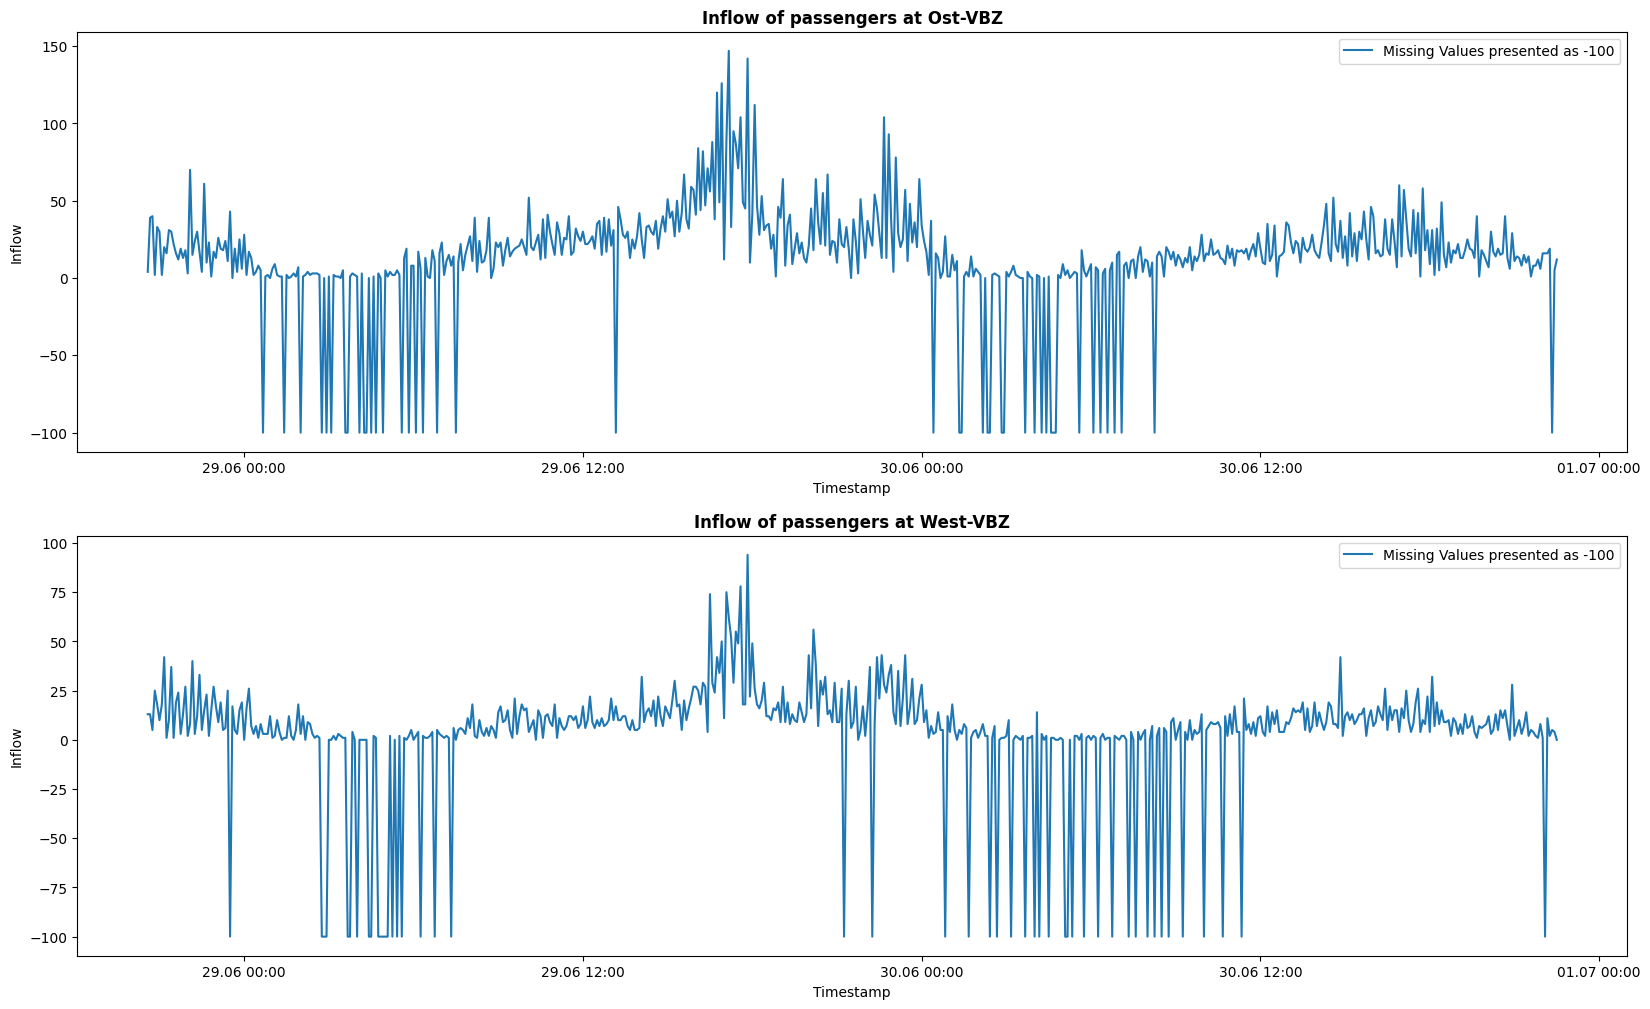

In [29]:
import matplotlib.dates as mdates
#Observe where missing values are located
healed_VBZ_mv = healed_VBZ.copy() #create a copy to work on
healed_VBZ_mv.fillna(-100, inplace = True) #Substitute missing values with negative value (impossible) in order to be able to identify them

#Plot the time series 
fig, axs = plt.subplots(2,1, figsize = (20, 12))

for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m %H:%M'))  #create a better readable x-axis
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12])) 
    
axs[0].plot(healed_VBZ_mv["Timestamp"][47300:47900], healed_VBZ_mv["Ost-VBZ Total"][47300:47900])
axs[0].set_xlabel("Timestamp")
axs[0].set_ylabel("Inflow")
axs[0].set_title("Inflow of passengers at Ost-VBZ", weight = "bold")
axs[0].legend(["Missing Values presented as -100"])
axs[1].plot(healed_VBZ_mv["Timestamp"][47300:47900], healed_VBZ_mv["West-VBZ total"][47300:47900])
axs[1].set_xlabel("Timestamp")
axs[1].set_ylabel("Inflow")
axs[1].set_title("Inflow of passengers at West-VBZ", weight = "bold")
axs[1].legend(["Missing Values presented as -100"])

### Dealing with missing values - Interpolation
Missing values seem to be distributed across the whole Timeseries and not concentrated in a single specific time interval. However, missing values seem to be appearing in a recurring pattern, with values missing regularly in the night hours comprised between 1 and 4 o' clock in the morning everyday. Despite this regularity, however, what happens at such an hour in the night isn't too relevant for the model prediction, since these hours where values are missing more often are typically hours during which there is no passengers in Hardbruecke. 

In order to obtain a cleaned Timeseries with equidistant observations, we can subsitute these missing values by interpolation, by taking the mean of the last and the next healthy datapoint available. Since we don't expect huge variations in the number of passengers occupying the station at such hours late in the night, the approximation should depict the reality faithfully enough.

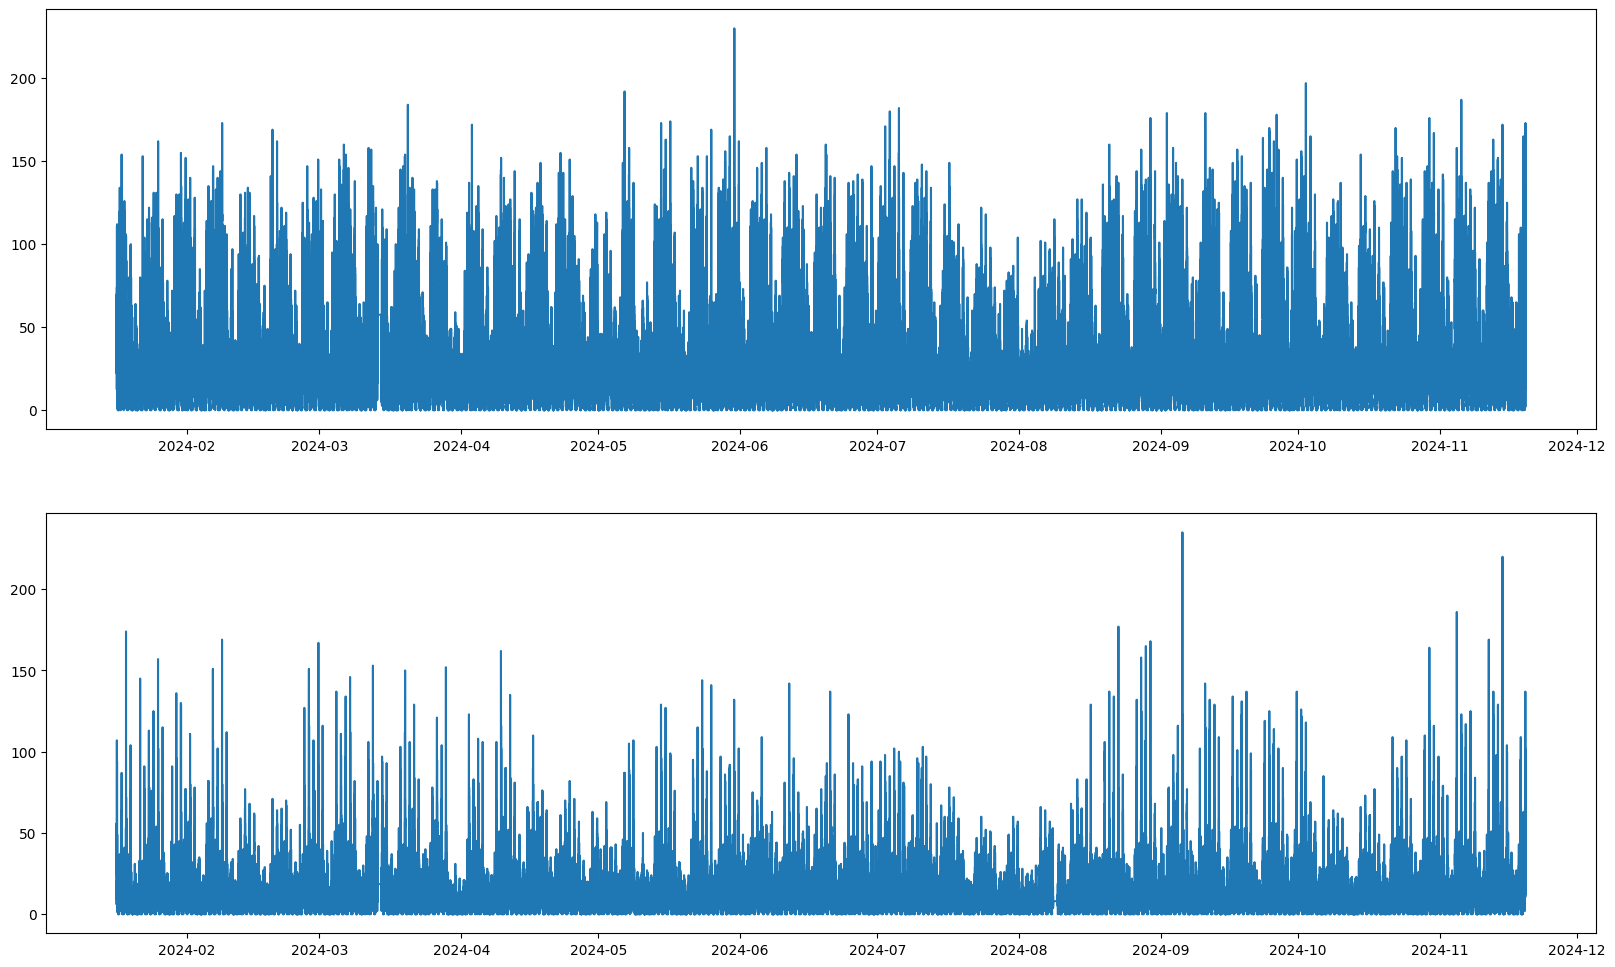

In [12]:
#Create columns with missing values substituted by interpolation, both by taking the value of the next healthy datapoint (forward fill)
# as well as by taking the value of the last available healthy datapoint (backward fill)
Ost_VBZ_Total_ff = healed_VBZ['Ost-VBZ Total'].ffill()
Ost_VBZ_Total_bf = healed_VBZ['Ost-VBZ Total'].bfill()

West_VBZ_total_ff = healed_VBZ['West-VBZ total'].ffill()
West_VBZ_total_bf = healed_VBZ['West-VBZ total'].bfill()

#Interpolate missing values by subsituting them by mean of forward and backward filling
healed_VBZ['Ost-VBZ Total'] = healed_VBZ['Ost-VBZ Total'].fillna((Ost_VBZ_Total_ff + Ost_VBZ_Total_bf) / 2)
healed_VBZ['West-VBZ total'] = healed_VBZ['West-VBZ total'].fillna((West_VBZ_total_ff + West_VBZ_total_bf) / 2)

#plot to see results
fig, axs = plt.subplots(2,1, figsize = (20, 12))
axs[0].plot(healed_VBZ["Timestamp"], healed_VBZ["Ost-VBZ Total"])
axs[1].plot(healed_VBZ["Timestamp"], healed_VBZ["West-VBZ total"])

### Cutting weather and VBZ datasets to let them have the same lenght

In [13]:
# Locate all observations after 16 january to match hardbrücke
#The hardbuecke Dataset has observations every five minutes starting from the 16th of January at 14:55
#Since we don't have data until the end of the current year yet, we can take all datapoints between 2024-01-16 14:55 and 2024-11-16 14:55
#to have exactly 10 months
healed_weather = healed_weather[healed_weather["Timestamp"] >= "2024-01-16 14:55:00"].reset_index(drop = True)
healed_weather = healed_weather[0:87841] #Cut healed_weather dataset for it to contain data from 16th of January 14:55 to the 16th of November 14:55
healed_VBZ = healed_VBZ[0:87841] #Do the same for healed_VBZ Dataset

#Check that the two datasets healed_weather and healed_VBZ have the same lenght
print(len(healed_VBZ) == len(healed_weather))

True


In [14]:
healed_VBZ

Timestamp  Ost-VBZ Total  West-VBZ total
0     2024-01-16 14:55:00           13.0            20.0
1     2024-01-16 15:00:00           14.0            11.0
2     2024-01-16 15:05:00           29.0             6.0
3     2024-01-16 15:10:00           18.0             9.0
4     2024-01-16 15:15:00           33.0            16.0
...                   ...            ...             ...
87836 2024-11-16 14:35:00           44.0             3.0
87837 2024-11-16 14:40:00           30.0            19.0
87838 2024-11-16 14:45:00           16.0            18.0
87839 2024-11-16 14:50:00           52.0             6.0
87840 2024-11-16 14:55:00           25.0            18.0

[87841 rows x 3 columns]

### Adding dummy variable for holidays and variable to day name. Merge healed_VBZ with holidays.

In [15]:
#Dummy for holidays
#Define which days of the years are holidays
#Taken from Zurich Government website
feiertage = pd.DataFrame({
	"Date": ["2024-01-01", "2024-01-02", "2024-03-28", "2024-03-29", "2024-04-01", "2024-04-15", "2024-05-01", "2024-05-08", "2024-05-09",
              "2024-05-10", "2024-05-20", "2024-08-01", "2024-09-09", "2024-12-24", "2024-12-25", "2024-12-26", "2024-12-27", "2024-12-30",
              "2024-12-31"]
})

feiertage["Date"] = pd.to_datetime(feiertage["Date"])
#Add value 1 (True) for holidays
feiertage["Holiday"] = 1

In [16]:
# Create date range for 2024
dates = pd.date_range(start="2024-01-01", end="2024-12-31", freq="D")

# Create a dataframe with names of the days of the week
calendar = pd.DataFrame({
    "Date": dates,
    "Day": dates.day_name()  
})
#Convert date column into datetime format
calendar["Date"] = pd.to_datetime(calendar["Date"])

#Initially assign value 0 (False) under the Holiday feature for all observations
calendar["Holiday"] = 0

# Put value 1 (True) under the Holiday feature for observations that correspond to those ones of feiertage
calendar2 = np.where(calendar["Date"].isin(feiertage["Date"]), 1, 0)
calendar["Holiday"] = calendar2

#Consider weekends as holidays as as well 
calendar.loc[calendar["Day"].isin(["Saturday", "Sunday"]), "Holiday"] = 1

#Extract only Date and Holiday column from the calendar Dataframe, since these ones are the features that we want to integrate in our data
holiday_df = calendar[["Date", "Holiday"]]

#Extend healed_holiday to match granularity of healed_VBZ
def extend_holidays(holiday_df):
    # Create a list to hold the expanded data
    extended_df = []
    
    for _, row in holiday_df.iterrows():
        
        date = pd.Timestamp(row['Date']).date()
        holiday_value = row['Holiday']
        
        # Generate 5-minute intervals for the whole day
        time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")
        
        # Append each timestamp with the holiday value
        extended_df.extend([(timestamp, holiday_value) for timestamp in time_range])
    
    # Create a new DataFrame from the expanded data
    holiday_df_extended = pd.DataFrame(extended_df, columns=["Timestamp", "Holiday"])
    return holiday_df_extended

healed_holiday = extend_holidays(holiday_df)

#Cutting healed_holiday to have the same lenght as healed_VB
healed_holiday = healed_holiday[4499:92340]

#Merge healed_holiday with healed_VBZ
healed_VBZ = pd.merge(healed_VBZ, healed_holiday, on = "Timestamp", how = "inner")

C:\Users\micha\AppData\Local\Temp\ipykernel_116616\3393714440.py:36: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=f"{date} 00:00:00", end=f"{date} 23:55:00", freq="5T")


### Adding features for previous observations up to t-288, which is a whole day.

healed_VBZ.sort_values(by = "Timestamp",ascending=False, inplace = True)

#Add new variable for ost to shift values back
healed_VBZ["t-1 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-1)
healed_VBZ["t-2 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-2)
healed_VBZ["t-3 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-3)
healed_VBZ["t-4 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-4)
healed_VBZ["t-5 Ost-VBZ"] = healed_VBZ["Ost-VBZ Total"].shift(-5)

#Add new variable for west to shift values back
healed_VBZ["t-1 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-1)
healed_VBZ["t-2 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-2)
healed_VBZ["t-3 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-3)
healed_VBZ["t-4 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-4)
healed_VBZ["t-5 West-VBZ"] = healed_VBZ["West-VBZ total"].shift(-5)

healed_VBZ.sort_values(by = "Timestamp",ascending=True, inplace = True)

In [17]:
#Split data into ost and west so we can do a seperate forecasting later
healed_VBZ_ost = healed_VBZ.copy()
healed_VBZ_west = healed_VBZ.copy()

In [18]:
# Assuming healed_VBZ is your DataFrame and 'Timestamp' is in datetime format
healed_VBZ_ost.sort_values(by="Timestamp", ascending=False, inplace=True)

# Define the number of shifts (24 for a whole day)
num_shifts = 288

# Loop to create shifted columns for 'Ost-VBZ Total'
for i in range(1, num_shifts + 1):
    healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)

healed_VBZ_ost.sort_values(by="Timestamp", ascending=True, inplace=True)

healed_VBZ_west.sort_values(by="Timestamp", ascending=False, inplace=True)

# Loop to create shifted columns for 'West-VBZ total'
for i in range(1, num_shifts + 1):
    healed_VBZ_west[f't-{i} West-VBZ'] = healed_VBZ_west['West-VBZ total'].shift(-i)

healed_VBZ_west.sort_values(by="Timestamp", ascending=True, inplace=True)

C:\Users\micha\AppData\Local\Temp\ipykernel_116616\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)
C:\Users\micha\AppData\Local\Temp\ipykernel_116616\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  healed_VBZ_ost[f't{-i} Ost-VBZ'] = healed_VBZ_ost['Ost-VBZ Total'].shift(-i)
C:\Users\micha\AppData\Local\Temp\ipykernel_116616\3366477083.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

### Merging Datasets together

Here we merge the VBZ ost/west data toghether with the weather ost/west data to create an X Matrix to later feed into our models.

In [19]:
#Merge the two dataframes weather and hardbruecke (healed_weather and healed_VBZ)
data_ost = pd.merge(healed_VBZ_ost, healed_weather, on = "Timestamp", how = "inner")
data_west = pd.merge(healed_VBZ_west, healed_weather, on = "Timestamp", how = "inner")
#Now that we included previous obsevations' values as features (up to t-288), there are, of course, new missing values for the first 288 
#observations. There is no data for these missing values, since we built this dataset by taking the first available value of the year 
#2024 from the hardbruecke dataset. To avoid problems in the modelling phase, we therefore drop the fist few days observations.
data_ost = data_ost[data_ost["Timestamp"] >= "2024-01-18 00:00:00"]
data_ost = data_ost[data_ost["Timestamp"] <= "2024-11-15 23:55:00"]
data_west = data_west[data_west["Timestamp"] >= "2024-01-18 00:00:00"]
data_west = data_west[data_west["Timestamp"] <= "2024-11-15 23:55:00"]

In [20]:
data_west

Timestamp  Ost-VBZ Total  West-VBZ total  Holiday  \
397   2024-01-18 00:00:00            1.0             4.0        0   
398   2024-01-18 00:05:00            3.5             5.0        0   
399   2024-01-18 00:10:00            6.0             3.0        0   
400   2024-01-18 00:15:00            2.0             1.0        0   
401   2024-01-18 00:20:00            1.5             1.0        0   
...                   ...            ...             ...      ...   
87656 2024-11-15 23:35:00            1.0            16.0        0   
87657 2024-11-15 23:40:00           76.0             6.0        0   
87658 2024-11-15 23:45:00           26.0             9.0        0   
87659 2024-11-15 23:50:00           21.0             3.0        0   
87660 2024-11-15 23:55:00           18.0            12.0        0   

       t-1 West-VBZ  t-2 West-VBZ  t-3 West-VBZ  t-4 West-VBZ  t-5 West-VBZ  \
397             3.0           2.0           4.0           6.0           7.0   
398             4.0           3.0           2.0           4.0           6.0   
399             5.0           4.0           3.0           2.0           4.0   
400             3.0           5.0           4.0           3.0           2.0   
401             1.0           3.0           5.0           4.0           3.0   
...             ...           ...           ...           ...           ...   
87656           6.0           9.0          20.0          25.0          26.0   
87657          16.0           6.0           9.0          20.0          25.0   
87658           6.0          16.0           6.0           9.0          20.0   
87659           9.0           6.0          16.0           6.0           9.0   
87660           3.0           9.0           6.0          16.0           6.0   

       t-6 West-VBZ  ...  wind_speed_avg_10min  wind_force_avg_10min  \
397             5.5  ...                   4.0                   4.0   
398             7.0  ...                   4.0                   4.0   
399             6.0  ...                   3.8                   3.8   
400             4.0  ...                   3.8                   3.8   
401             2.0  ...                   4.3                   4.3   
...             ...  ...                   ...                   ...   
87656          50.0  ...                   1.6                   1.6   
87657          26.0  ...                   1.4                   1.4   
87658          25.0  ...                   1.4                   1.4   
87659          20.0  ...                   1.2                   1.2   
87660           9.0  ...                   1.2                   1.2   

       wind_direction  windchill  barometric_pressure_qfe  precipitation  \
397              55.0        6.0                    947.7            0.1   
398              55.0        6.0                    947.7            0.1   
399              50.0        6.1                    947.6            0.0   
400              50.0        6.1                    947.6            0.0   
401              63.0        5.8                    947.6            0.1   
...               ...        ...                      ...            ...   
87656           299.0        1.8                    978.2            0.0   
87657           307.0        2.1                    978.2            0.0   
87658           307.0        2.1                    978.2            0.0   
87659           297.0        2.1                    978.1            0.0   
87660           297.0        2.1                    978.1            0.0   

       dew_point  global_radiation  humidity  water_level  
397          7.3               0.0      86.0       405.83  
398          7.3               0.0      86.0       405.83  
399          7.3               0.0      86.0       405.84  
400          7.3               0.0      86.0       405.84  
401          7.2               0.0      87.0       405.84  
...          ...               ...       ...          ...  
87656        1.6               0.0      

# AR Modell benchmark prediction

In [31]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install statsmodels


#import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.tsa.stattools import acf

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\micha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\micha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\micha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\micha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\micha\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



In [ ]:
#Import data set 
df = pd.read_csv(r"C:\Users\USER\Downloads\cleaned_data_TM_1.csv")
df

Timestamp  Ost-VBZ Total  West-VBZ total
0      2024-01-17 14:55:00           47.0            19.0
1      2024-01-17 15:00:00           35.0            25.0
2      2024-01-17 15:05:00           25.0             9.0
3      2024-01-17 15:10:00           24.0            15.0
4      2024-01-17 15:15:00           48.0            24.0
...                    ...            ...             ...
87548  2024-11-16 14:35:00           44.0             3.0
87549  2024-11-16 14:40:00           30.0            19.0
87550  2024-11-16 14:45:00           16.0            18.0
87551  2024-11-16 14:50:00           52.0             6.0
87552  2024-11-16 14:55:00           25.0            18.0

[87553 rows x 3 columns]

In [35]:
# Data for the eastern side
df_ost = df[["Timestamp","Ost-VBZ Total"]]
df_ost

Timestamp  Ost-VBZ Total
0      2024-01-17 14:55:00           47.0
1      2024-01-17 15:00:00           35.0
2      2024-01-17 15:05:00           25.0
3      2024-01-17 15:10:00           24.0
4      2024-01-17 15:15:00           48.0
...                    ...            ...
87548  2024-11-16 14:35:00           44.0
87549  2024-11-16 14:40:00           30.0
87550  2024-11-16 14:45:00           16.0
87551  2024-11-16 14:50:00           52.0
87552  2024-11-16 14:55:00           25.0

[87553 rows x 2 columns]

In [36]:
# Data for the western side
df_west = df[["Timestamp","West-VBZ total"]]
df_west

Timestamp  West-VBZ total
0      2024-01-17 14:55:00            19.0
1      2024-01-17 15:00:00            25.0
2      2024-01-17 15:05:00             9.0
3      2024-01-17 15:10:00            15.0
4      2024-01-17 15:15:00            24.0
...                    ...             ...
87548  2024-11-16 14:35:00             3.0
87549  2024-11-16 14:40:00            19.0
87550  2024-11-16 14:45:00            18.0
87551  2024-11-16 14:50:00             6.0
87552  2024-11-16 14:55:00            18.0

[87553 rows x 2 columns]

In [37]:
# test stationarity for the eastern data
result_ost = adfuller(df_ost["Ost-VBZ Total"])
print("ADF Statistic:", result_ost[0])
print("p-value:", result_ost[1])
print("Critical Values:", result_ost[4])
result_ost

ADF Statistic: -36.018337257886294
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4304247473010774), '5%': np.float64(-2.8615730370839483), '10%': np.float64(-2.5667875844928134)}


(np.float64(-36.018337257886294),
 0.0,
 64,
 87488,
 {'1%': np.float64(-3.4304247473010774),
  '5%': np.float64(-2.8615730370839483),
  '10%': np.float64(-2.5667875844928134)},
 np.float64(702908.9164711933))

In [38]:
# test stationarity for the western data
result_west = adfuller(df_west["West-VBZ total"])
print("ADF Statistic:", result_west[0])
print("p-value:", result_west[1])
print("Critical Values:", result_west[4])
result_west

ADF Statistic: -33.89849369769431
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430424749009911), '5%': np.float64(-2.861573037839215), '10%': np.float64(-2.566787584894817)}


(np.float64(-33.89849369769431),
 0.0,
 66,
 87486,
 {'1%': np.float64(-3.430424749009911),
  '5%': np.float64(-2.861573037839215),
  '10%': np.float64(-2.566787584894817)},
 np.float64(617580.4382319433))

In [39]:
# because the p-values are in each case lower than 0.05, we come to the conclusion that the 
# dataset on both sides is stationary, meaning that no differcing is necessary

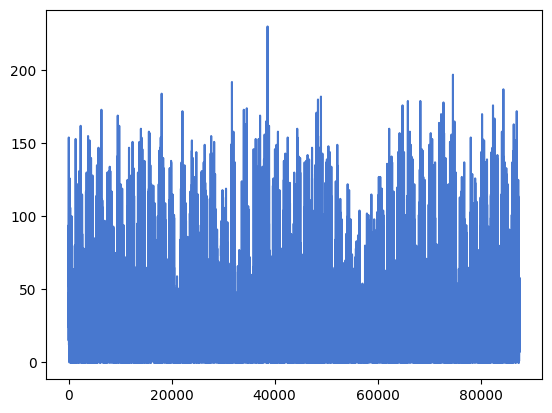

In [40]:
# plot the eastern side 
plt.plot(df_ost["Ost-VBZ Total"])

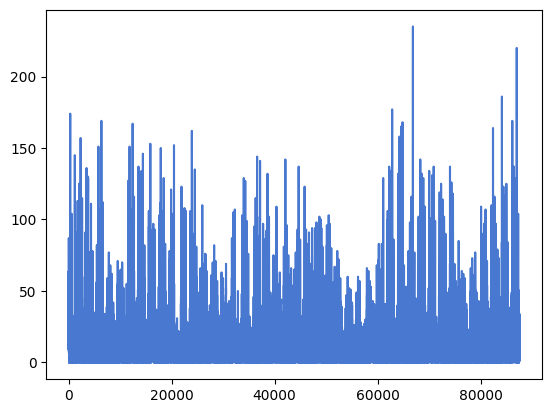

In [41]:
# plot the western side of the dataset
plt.plot(df_west["West-VBZ total"])

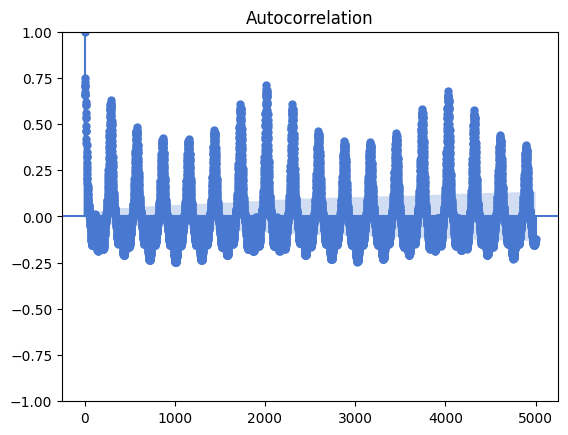

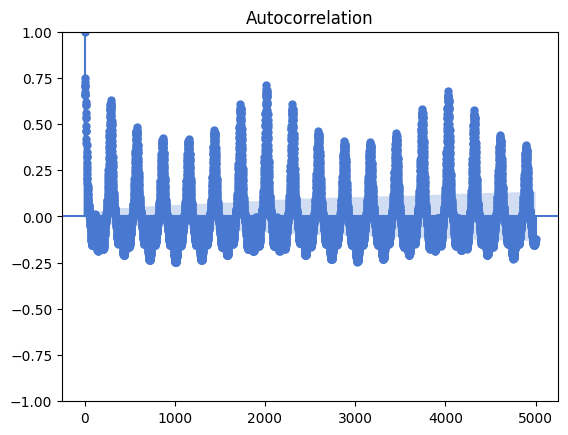

In [42]:
# plot the ACF of the western side of the data
plot_acf(df_ost["Ost-VBZ Total"], lags = 5000)
# it is a sinus function approximately

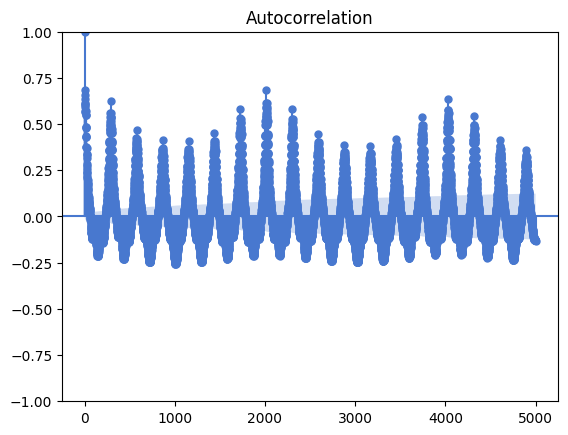

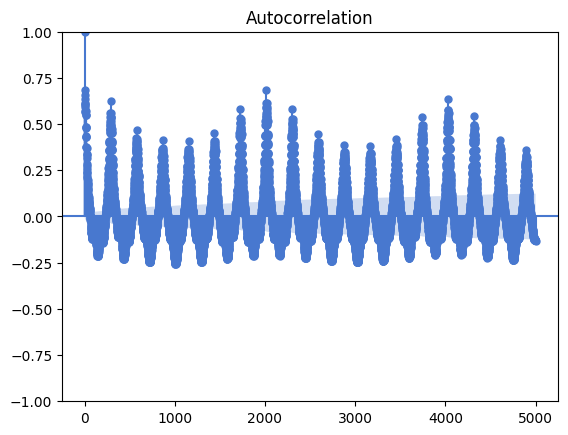

In [43]:
# plot the acf for the western side of the data  side
plot_acf(df_west["West-VBZ total"], lags = 5000)
# like the western side, it is a sinus function approximately

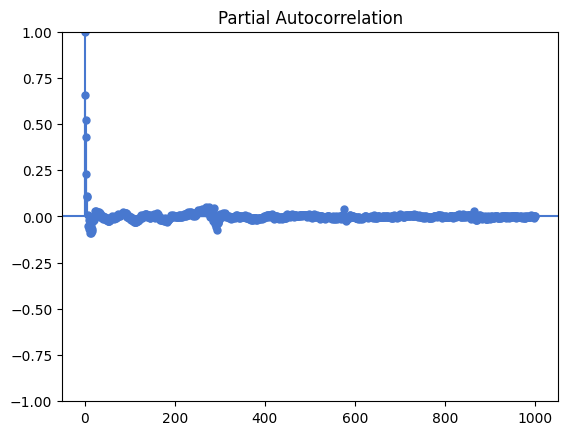

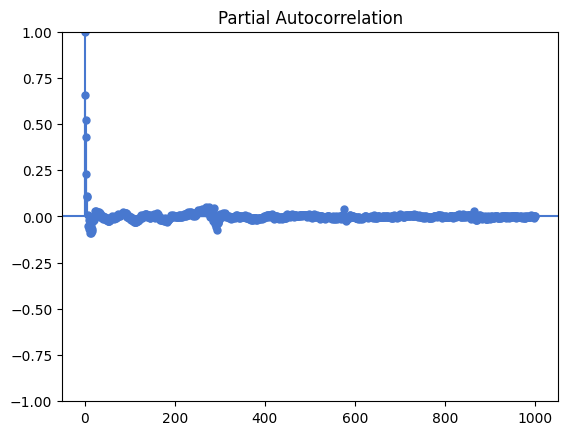

In [44]:
# plot the pacf function for the eastern side
plot_pacf(df_ost["Ost-VBZ Total"], lags = 1000)

# it apparently converges to zero

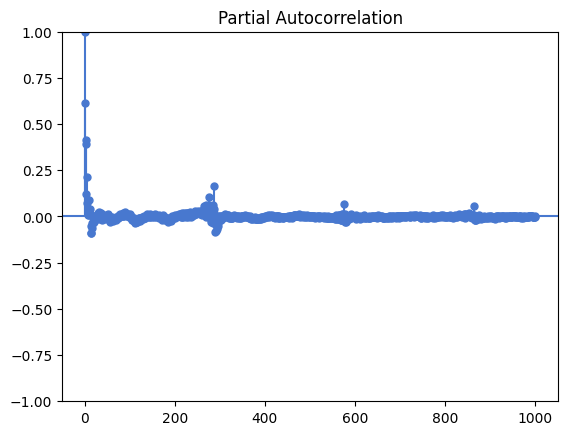

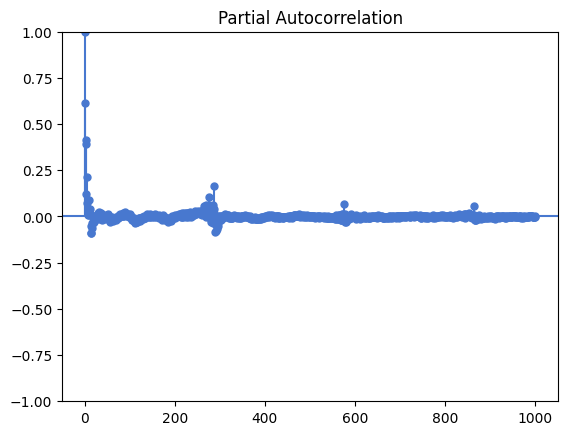

In [45]:
# plot the pacf function for the western side
plot_pacf(df_west["West-VBZ total"], lags = 1000)

# it also apparently convergers to zero

In [46]:
# Because the ACFs are sinus functions and the PACFs converge to zero, we come to the conclusion
# that we should use the AR model (autoregressive) based on the decision table shown in the lecture

In [47]:
# decompostion of the eastern side of the dataset following an addivitive model
decomposition_ost = seasonal_decompose(df_ost["Ost-VBZ Total"], model='additive', period = 1000, filt=None, two_sided=True, extrapolate_trend=0)
decomposition_ost

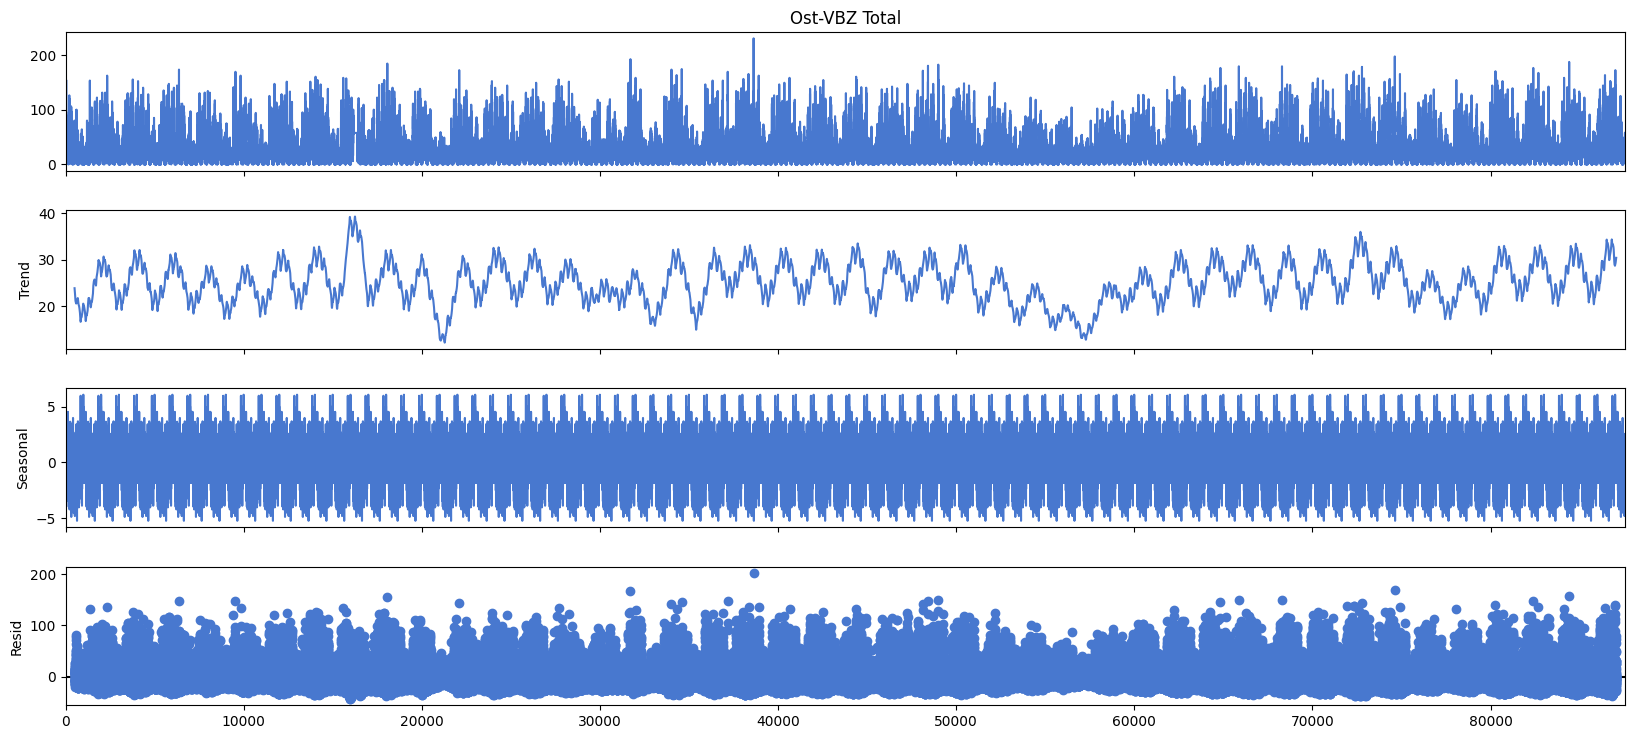

In [48]:
fig = decomposition_ost.plot()
fig.set_size_inches((18, 8))  ##
plt.show()

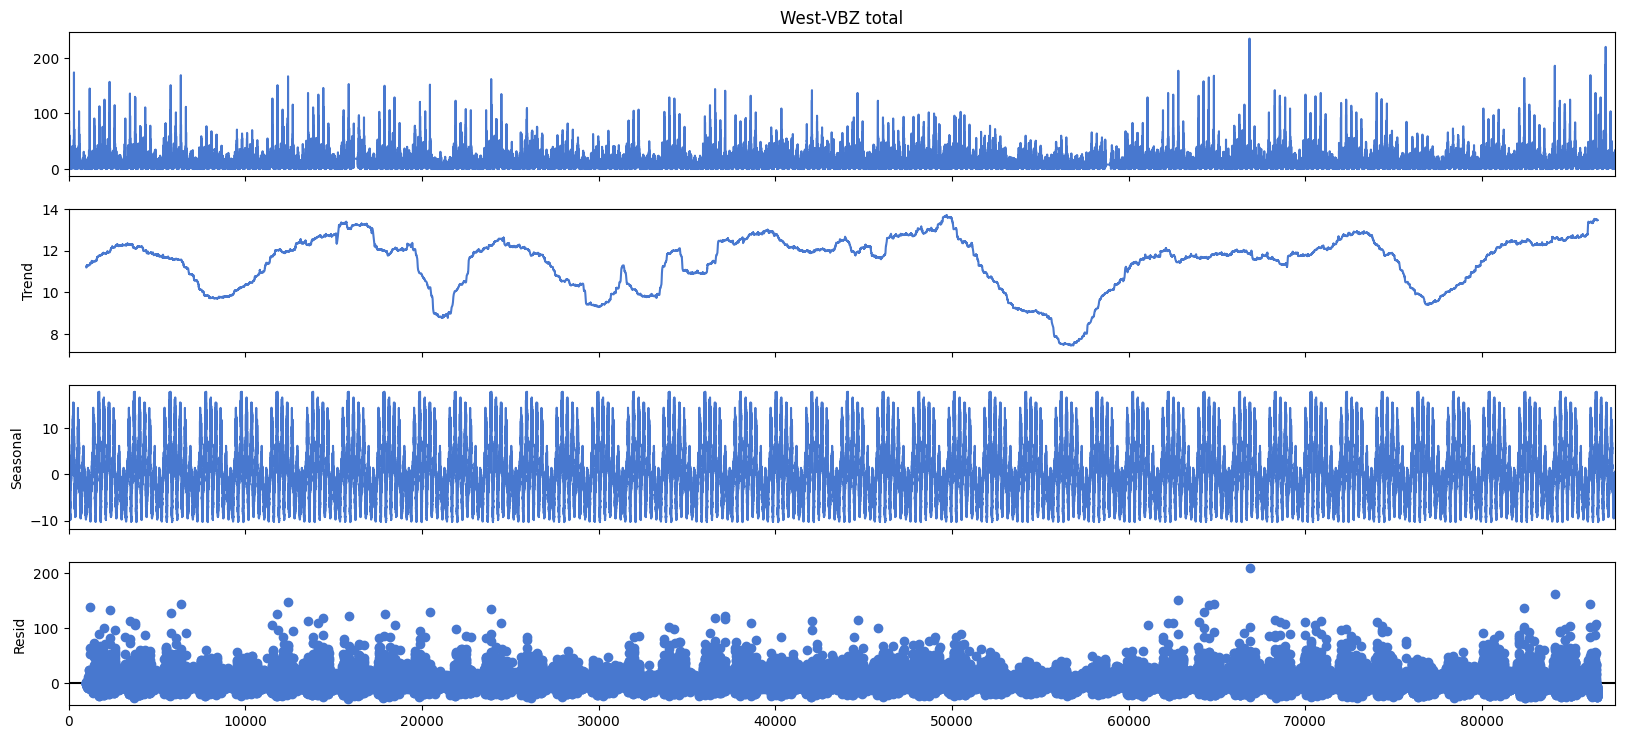

In [49]:
# reproduce the decomposition for the other side foolowing an addiviitve model
decomposition_west = seasonal_decompose(df_west["West-VBZ total"], model='additive', filt=None, period=2018, two_sided=True, extrapolate_trend=0)
decomposition_west
fig = decomposition_west.plot()
fig.set_size_inches((18, 8))  ##
plt.show()

In [50]:
acf_ost = acf(df_ost["Ost-VBZ Total"], fft = True)
acf_ost

array([1.        , 0.65548504, 0.72640157, 0.74864418, 0.70792639,
       0.69959834, 0.71044202, 0.67299562, 0.65682109, 0.66101134,
       0.62141618, 0.60355613, 0.60359159, 0.56193679, 0.53803395,
       0.53042181, 0.49126628, 0.46343473, 0.45988985, 0.41990207,
       0.3968255 , 0.38449467, 0.35043085, 0.32736342, 0.3193509 ,
       0.2882743 , 0.26703869, 0.25351467, 0.23043636, 0.21015413,
       0.20157399, 0.18165992, 0.16549148, 0.15386551, 0.14308793,
       0.12369042, 0.12144744, 0.1076242 , 0.09632772, 0.08988544,
       0.08377966, 0.06987429, 0.07066281, 0.06272866, 0.05453974,
       0.05077172, 0.04921284, 0.03908245, 0.03602126, 0.03536536])

In [51]:
acf_west= acf(df_west["West-VBZ total"], fft = True)
acf_west

array([1.        , 0.61363899, 0.63595848, 0.68506698, 0.60191842,
       0.59465157, 0.65844631, 0.56612041, 0.5707896 , 0.60778058,
       0.54648495, 0.54916852, 0.5725445 , 0.48582406, 0.47821205,
       0.48536651, 0.42873117, 0.42753427, 0.43599127, 0.37846276,
       0.37582754, 0.36914834, 0.33857035, 0.33070556, 0.31911793,
       0.28232715, 0.27398306, 0.25870211, 0.24063034, 0.2368827 ,
       0.22072697, 0.20789657, 0.19869445, 0.17918259, 0.17508406,
       0.16499404, 0.15105096, 0.14750338, 0.13549675, 0.11708841,
       0.12306381, 0.11523821, 0.09946371, 0.10464679, 0.09355697,
       0.07650293, 0.08558466, 0.07476997, 0.06507909, 0.07052562])

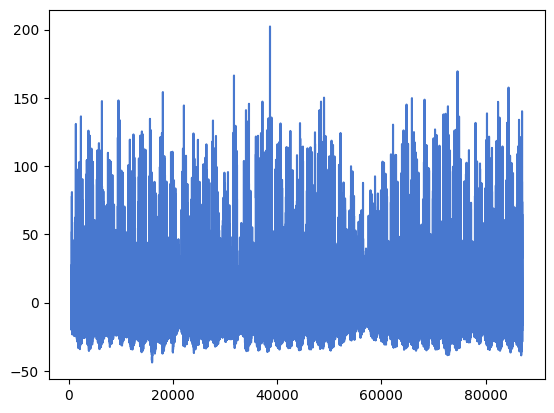

In [52]:
# Plot and Calculate the residuals for the eastern side
residuals_ost = df_ost["Ost-VBZ Total"] - decomposition_ost.trend - decomposition_ost.seasonal
residuals_ost.dropna()

plt.plot(residuals_ost)

plt.show()

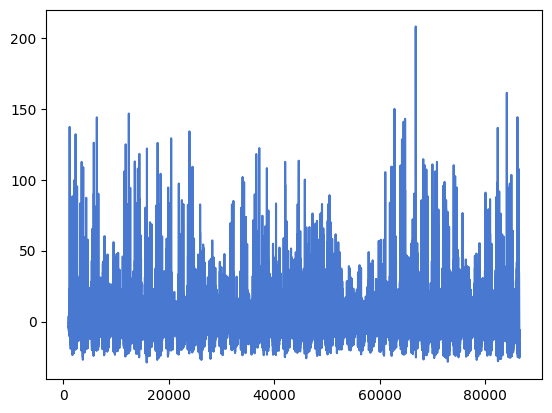

In [53]:
# calculate and plot the residuals of the western side
residuals_west = df_west["West-VBZ total"] - decomposition_west.trend - decomposition_west.seasonal
residuals_west.dropna()

plt.plot(residuals_west)

plt.show()

In [54]:
# Calculate unit root test for residuals on the eastern side
result_residualsost = adfuller(residuals_ost.dropna())
print("ADF Statistic:", result_residualsost[0])
print("p-value:", result_residualsost[1])
print("Critical Values:", result_residualsost[4])
result_residualsost

ADF Statistic: -38.28993988105583
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4304256124515544), '5%': np.float64(-2.86157341946143), '10%': np.float64(-2.5667877880199206)}


(np.float64(-38.28993988105583),
 0.0,
 65,
 86487,
 {'1%': np.float64(-3.4304256124515544),
  '5%': np.float64(-2.86157341946143),
  '10%': np.float64(-2.5667877880199206)},
 np.float64(693727.4147649574))

In [55]:
# Calculate unit root test for residuals on the western side
result_residualswest = adfuller(residuals_west.dropna())
print("ADF Statistic:", result_residualswest[0])
print("p-value:", result_residualswest[1])
print("Critical Values:", result_residualswest[4])
result_residualswest

ADF Statistic: -40.90077617035773
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430426513079708), '5%': np.float64(-2.8615738175191465), '10%': np.float64(-2.5667879998931276)}


(np.float64(-40.90077617035773),
 0.0,
 65,
 85469,
 {'1%': np.float64(-3.430426513079708),
  '5%': np.float64(-2.8615738175191465),
  '10%': np.float64(-2.5667879998931276)},
 np.float64(599087.6783651737))

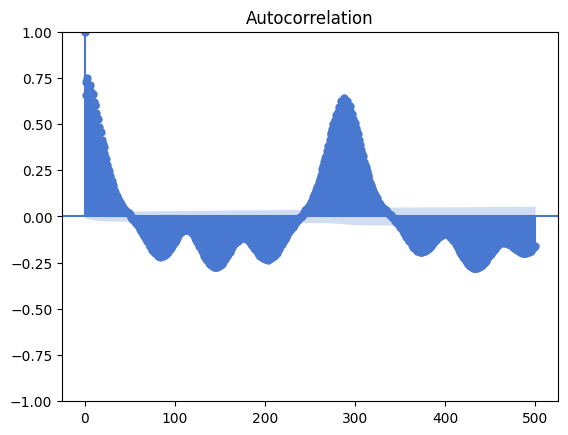

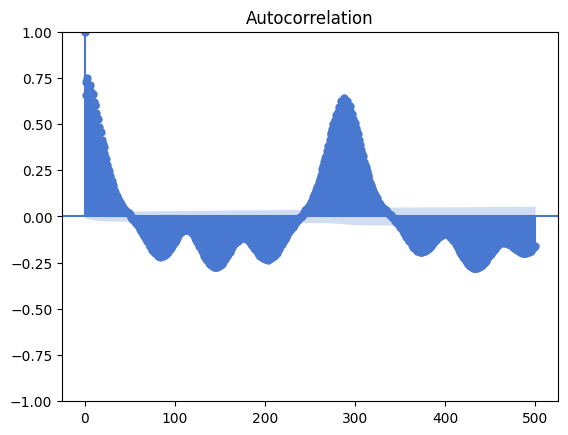

In [56]:
# Plot the ACF function for the residuals on the eastern side 
plot_acf(residuals_ost.dropna(),lags = 500)

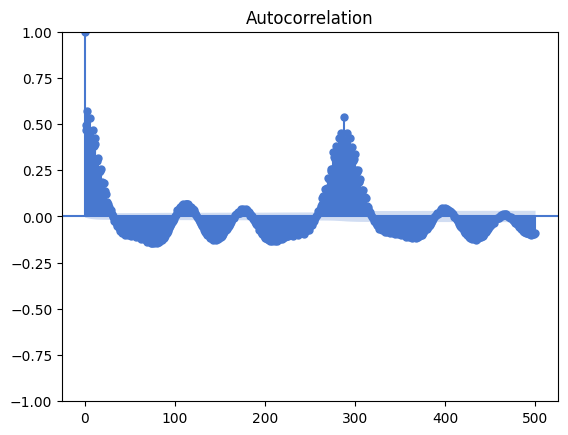

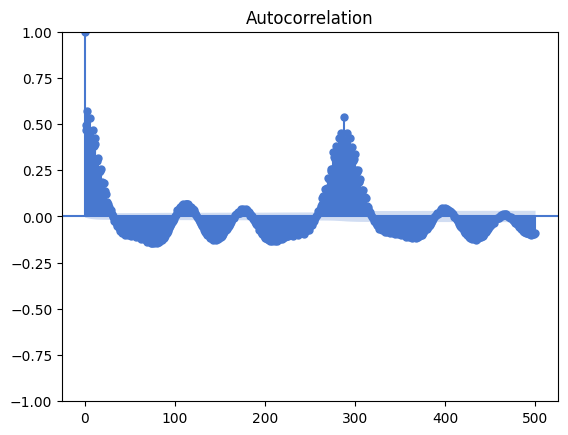

In [57]:
# Plot the ACF function for the residuals on the western side 

plot_acf(residuals_west.dropna(),lags = 500)

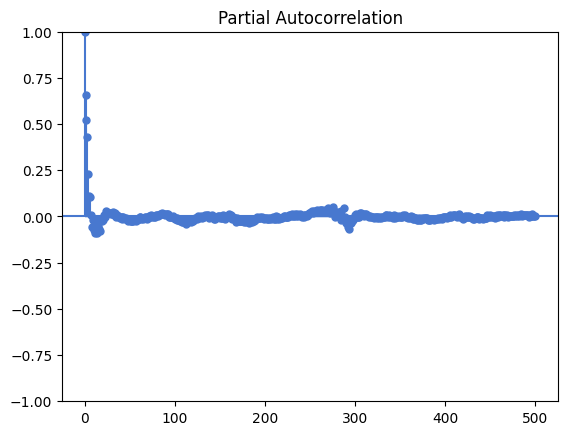

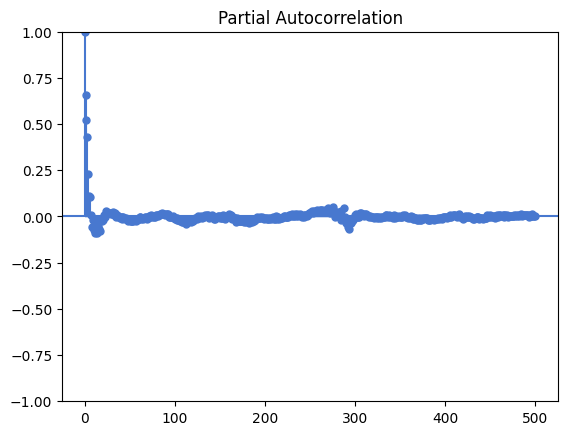

In [58]:
# Plot the PACF function for the residuals on the eastern side 

plot_pacf(residuals_ost.dropna(),lags = 500)

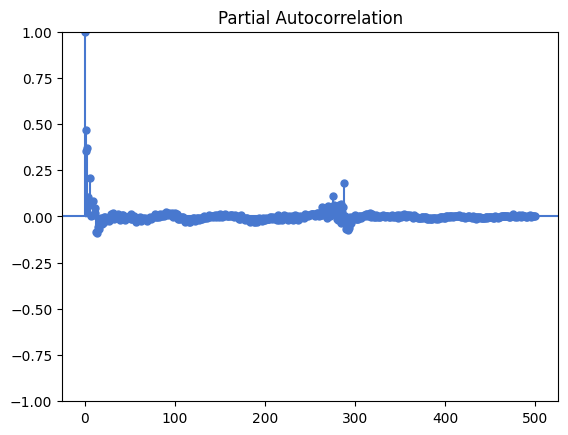

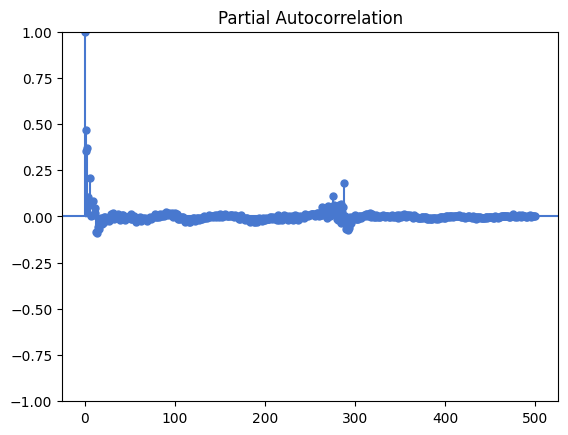

In [59]:
# Plot the PACF function for the residuals on the Western side 

plot_pacf(residuals_west.dropna(),lags = 500)

In [60]:
# Forecasting for the ost side
# We train our model with train_ost and test_ost
import sklearn.metrics
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error
df_ost["Ost-VBZ Total"]
df_west["West-VBZ total"]
# 80.58% for training  following a expanding window validation
# we choose this exact number to have full days in our training and testing sets

df_ost_train = int(len(df_ost)*0.808580858085808580858085808580858085808580858085)
train_ost ,test_ost = df_ost[:df_ost_train], df_ost[df_ost_train:]

from sklearn.model_selection import TimeSeriesSplit
# rolling windows
tscv = TimeSeriesSplit(n_splits=10)

len(train_ost),len(test_ost)
# We have (70560/288 = 245) days in our training set and 58 days for our testing set 

(70793, 16760)

In [61]:
# Create and train the autoregressive model
# determine number of lags
lags = 288
ar_model_ost = AutoReg(train_ost["Ost-VBZ Total"], lags=lags)
results_ar_ost = ar_model_ost.fit()

In [62]:
# Make predictions on the testing set for the eastern side
y_pred_ost = results_ar_ost.predict(start=len(train_ost["Ost-VBZ Total"]), end=len(train_ost["Ost-VBZ Total"]) + len(test_ost["Ost-VBZ Total"])-1)
#print(y_pred)
y_pred_ost

70793    12.347513
70794    14.559841
70795    15.292900
70796    18.139363
70797    12.488481
           ...    
87548    24.808934
87549    24.809159
87550    24.809408
87551    24.809681
87552    24.809979
Length: 16760, dtype: float64

In [63]:
# Calculate MAE and RMSE for the eastern side
mae_ost = mean_absolute_error(test_ost["Ost-VBZ Total"], y_pred_ost)
rmse_ost = mean_squared_error(test_ost["Ost-VBZ Total"], y_pred_ost)
print(f'Mean Absolute Error: {mae_ost:.2f}')
print(f'Root Mean Squared Error: {rmse_ost:.2f}')

Mean Absolute Error: 18.59
Root Mean Squared Error: 640.02


C:\Users\micha\AppData\Local\Temp\ipykernel_128568\2464037810.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ost["Timestamp"] = pd.to_datetime(test_ost["Timestamp"])
C:\Users\micha\AppData\Local\Temp\ipykernel_128568\2464037810.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ost["Timestamp"] = pd.to_datetime(train_ost["Timestamp"])
C:\Users\micha\AppData\Local\Temp\ipykernel_128568\2464037810.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min

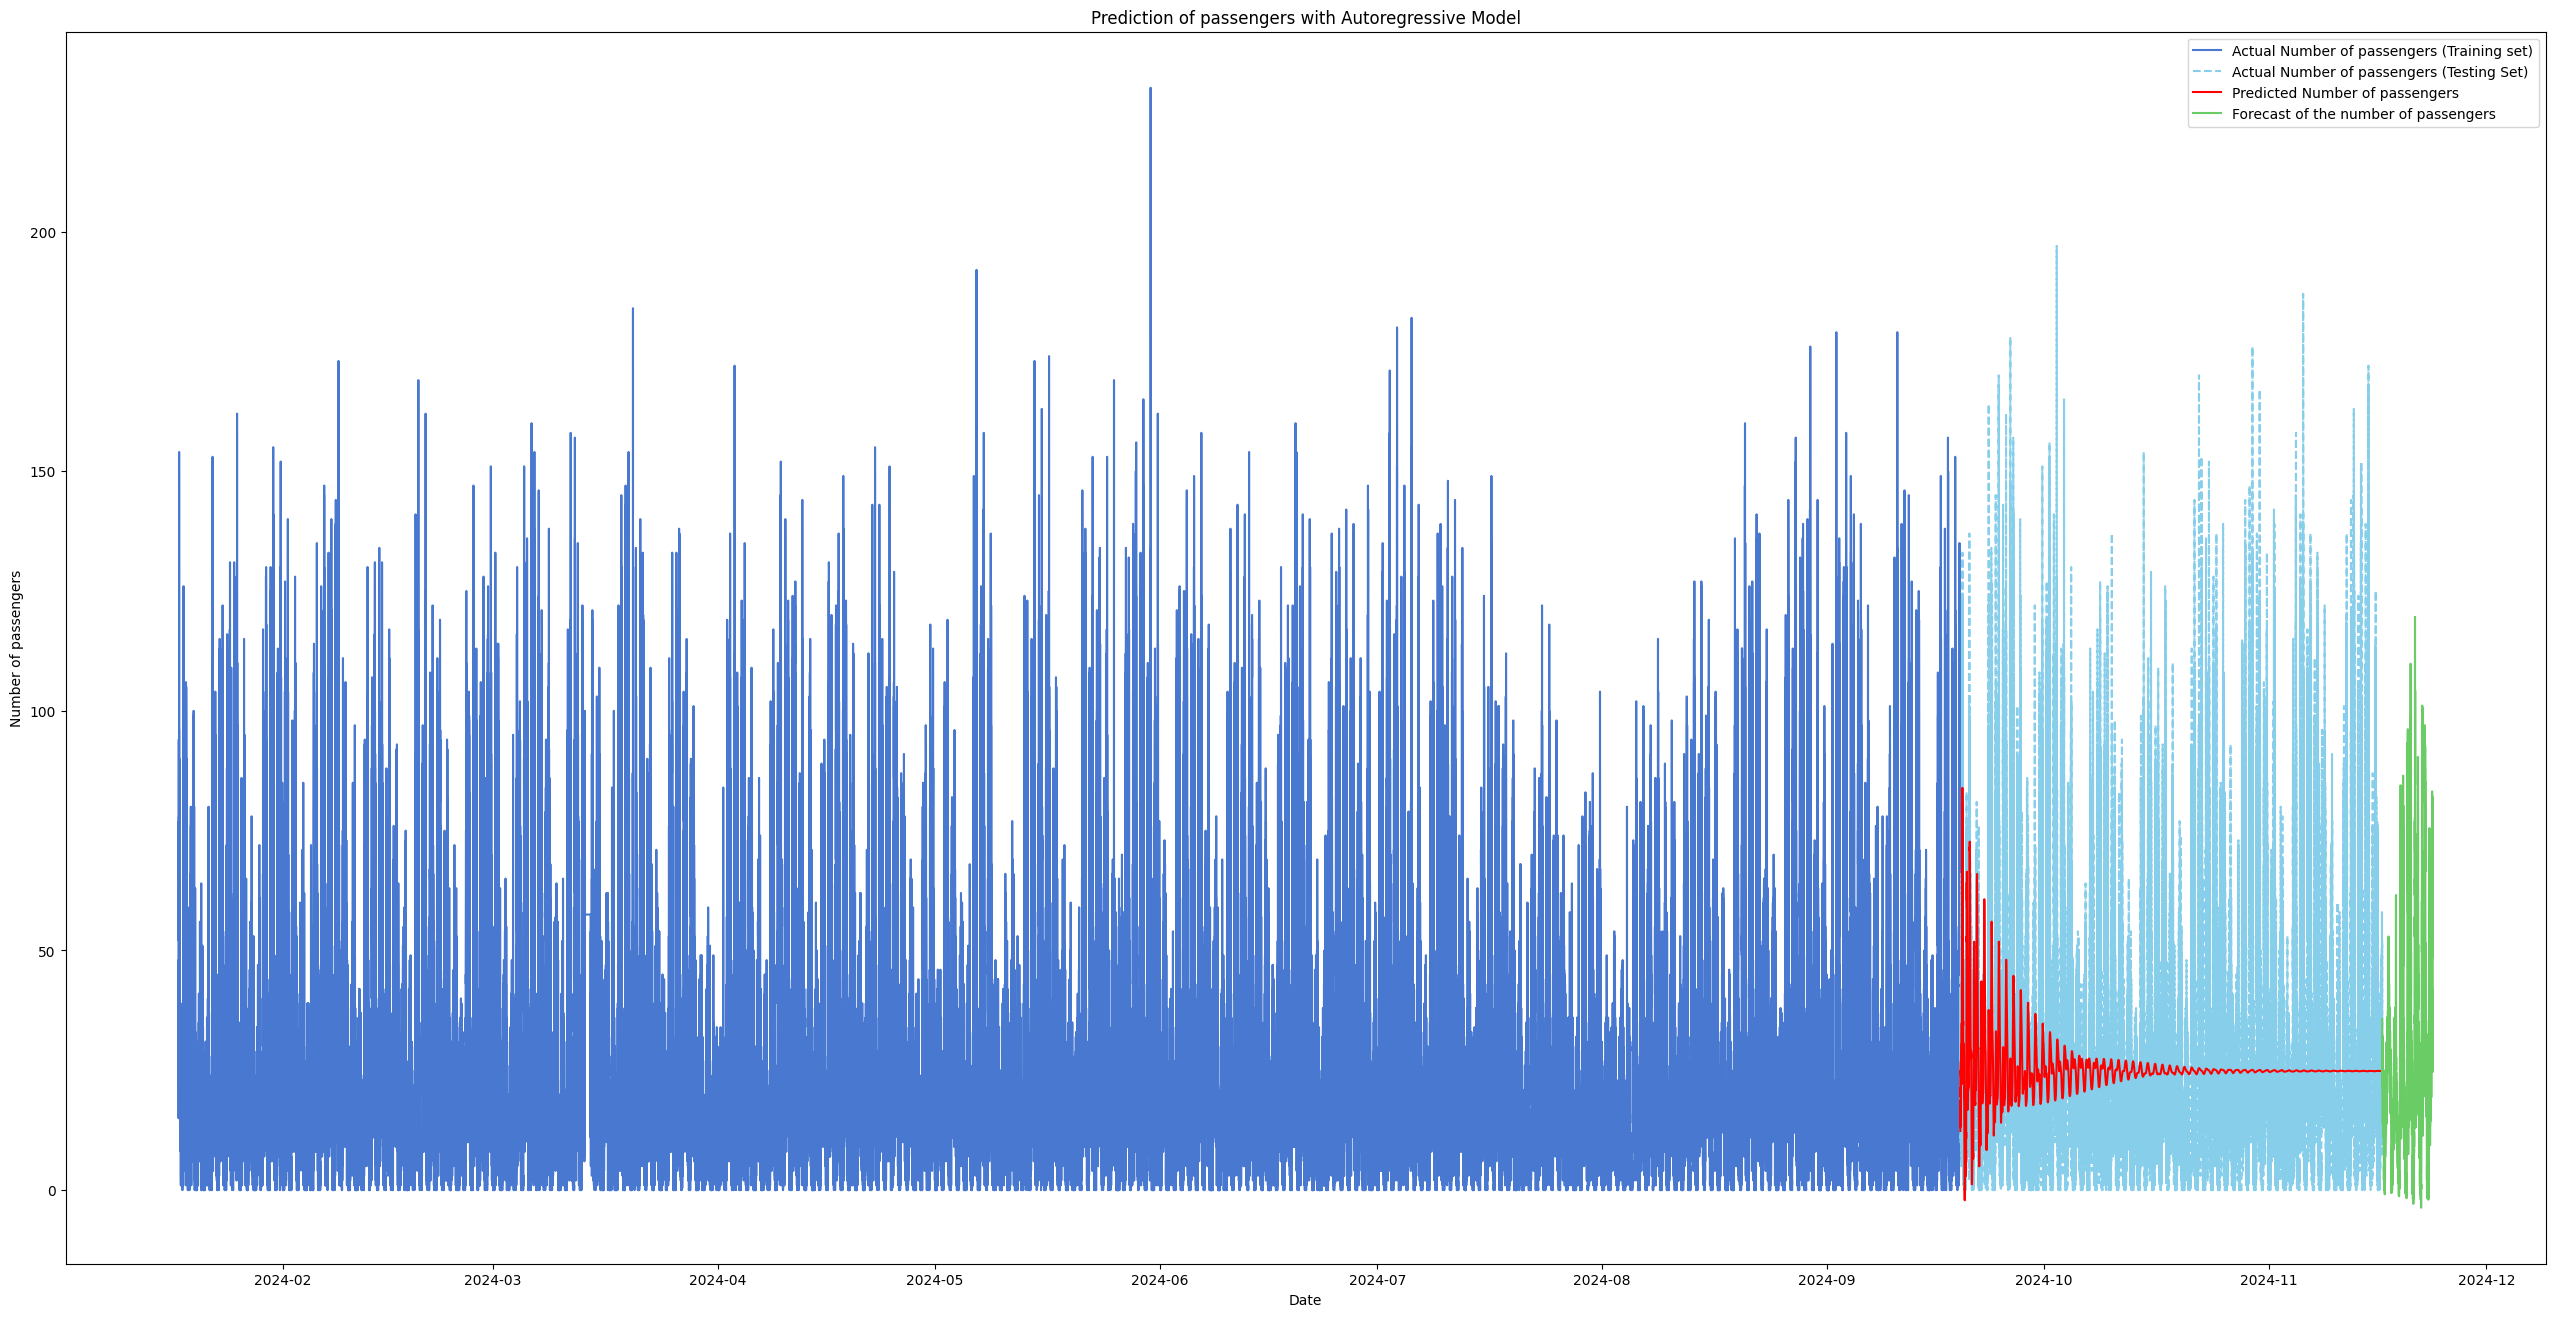

In [64]:
# Number of 5 minutes intervals in one day (288)
day = 288
# Number of 5-minutes intervals in our week (7 days)
forecast_steps_ost = 7*day
# convert stamp into datetime
test_ost["Timestamp"] = pd.to_datetime(test_ost["Timestamp"])
train_ost["Timestamp"] = pd.to_datetime(train_ost["Timestamp"])

# Make future predictions
future_predictions_ost = results_ar_ost.predict(start=len(test_ost), end=len(test_ost) + forecast_steps_ost - 1)
# determine future dates
future_dates_ost = pd.date_range(start=test_ost["Timestamp"].iloc[-1], periods=forecast_steps_ost, freq='5T')

# Plot training set, testing set, prediction on our data testing set, and future predictions
plt.figure(figsize=(32, 16))
plt.plot(train_ost["Timestamp"],train_ost["Ost-VBZ Total"], label = "Actual Number of passengers (Training set)")
plt.plot(test_ost["Timestamp"],test_ost["Ost-VBZ Total"], label='Actual Number of passengers (Testing Set)', linestyle = "--",color = "skyblue")
plt.plot(test_ost["Timestamp"],y_pred_ost, label='Predicted Number of passengers', color = "red")
plt.plot(future_dates_ost, future_predictions_ost, label = "Forecast of the number of passengers")

plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Prediction of passengers with Autoregressive Model')
plt.show()



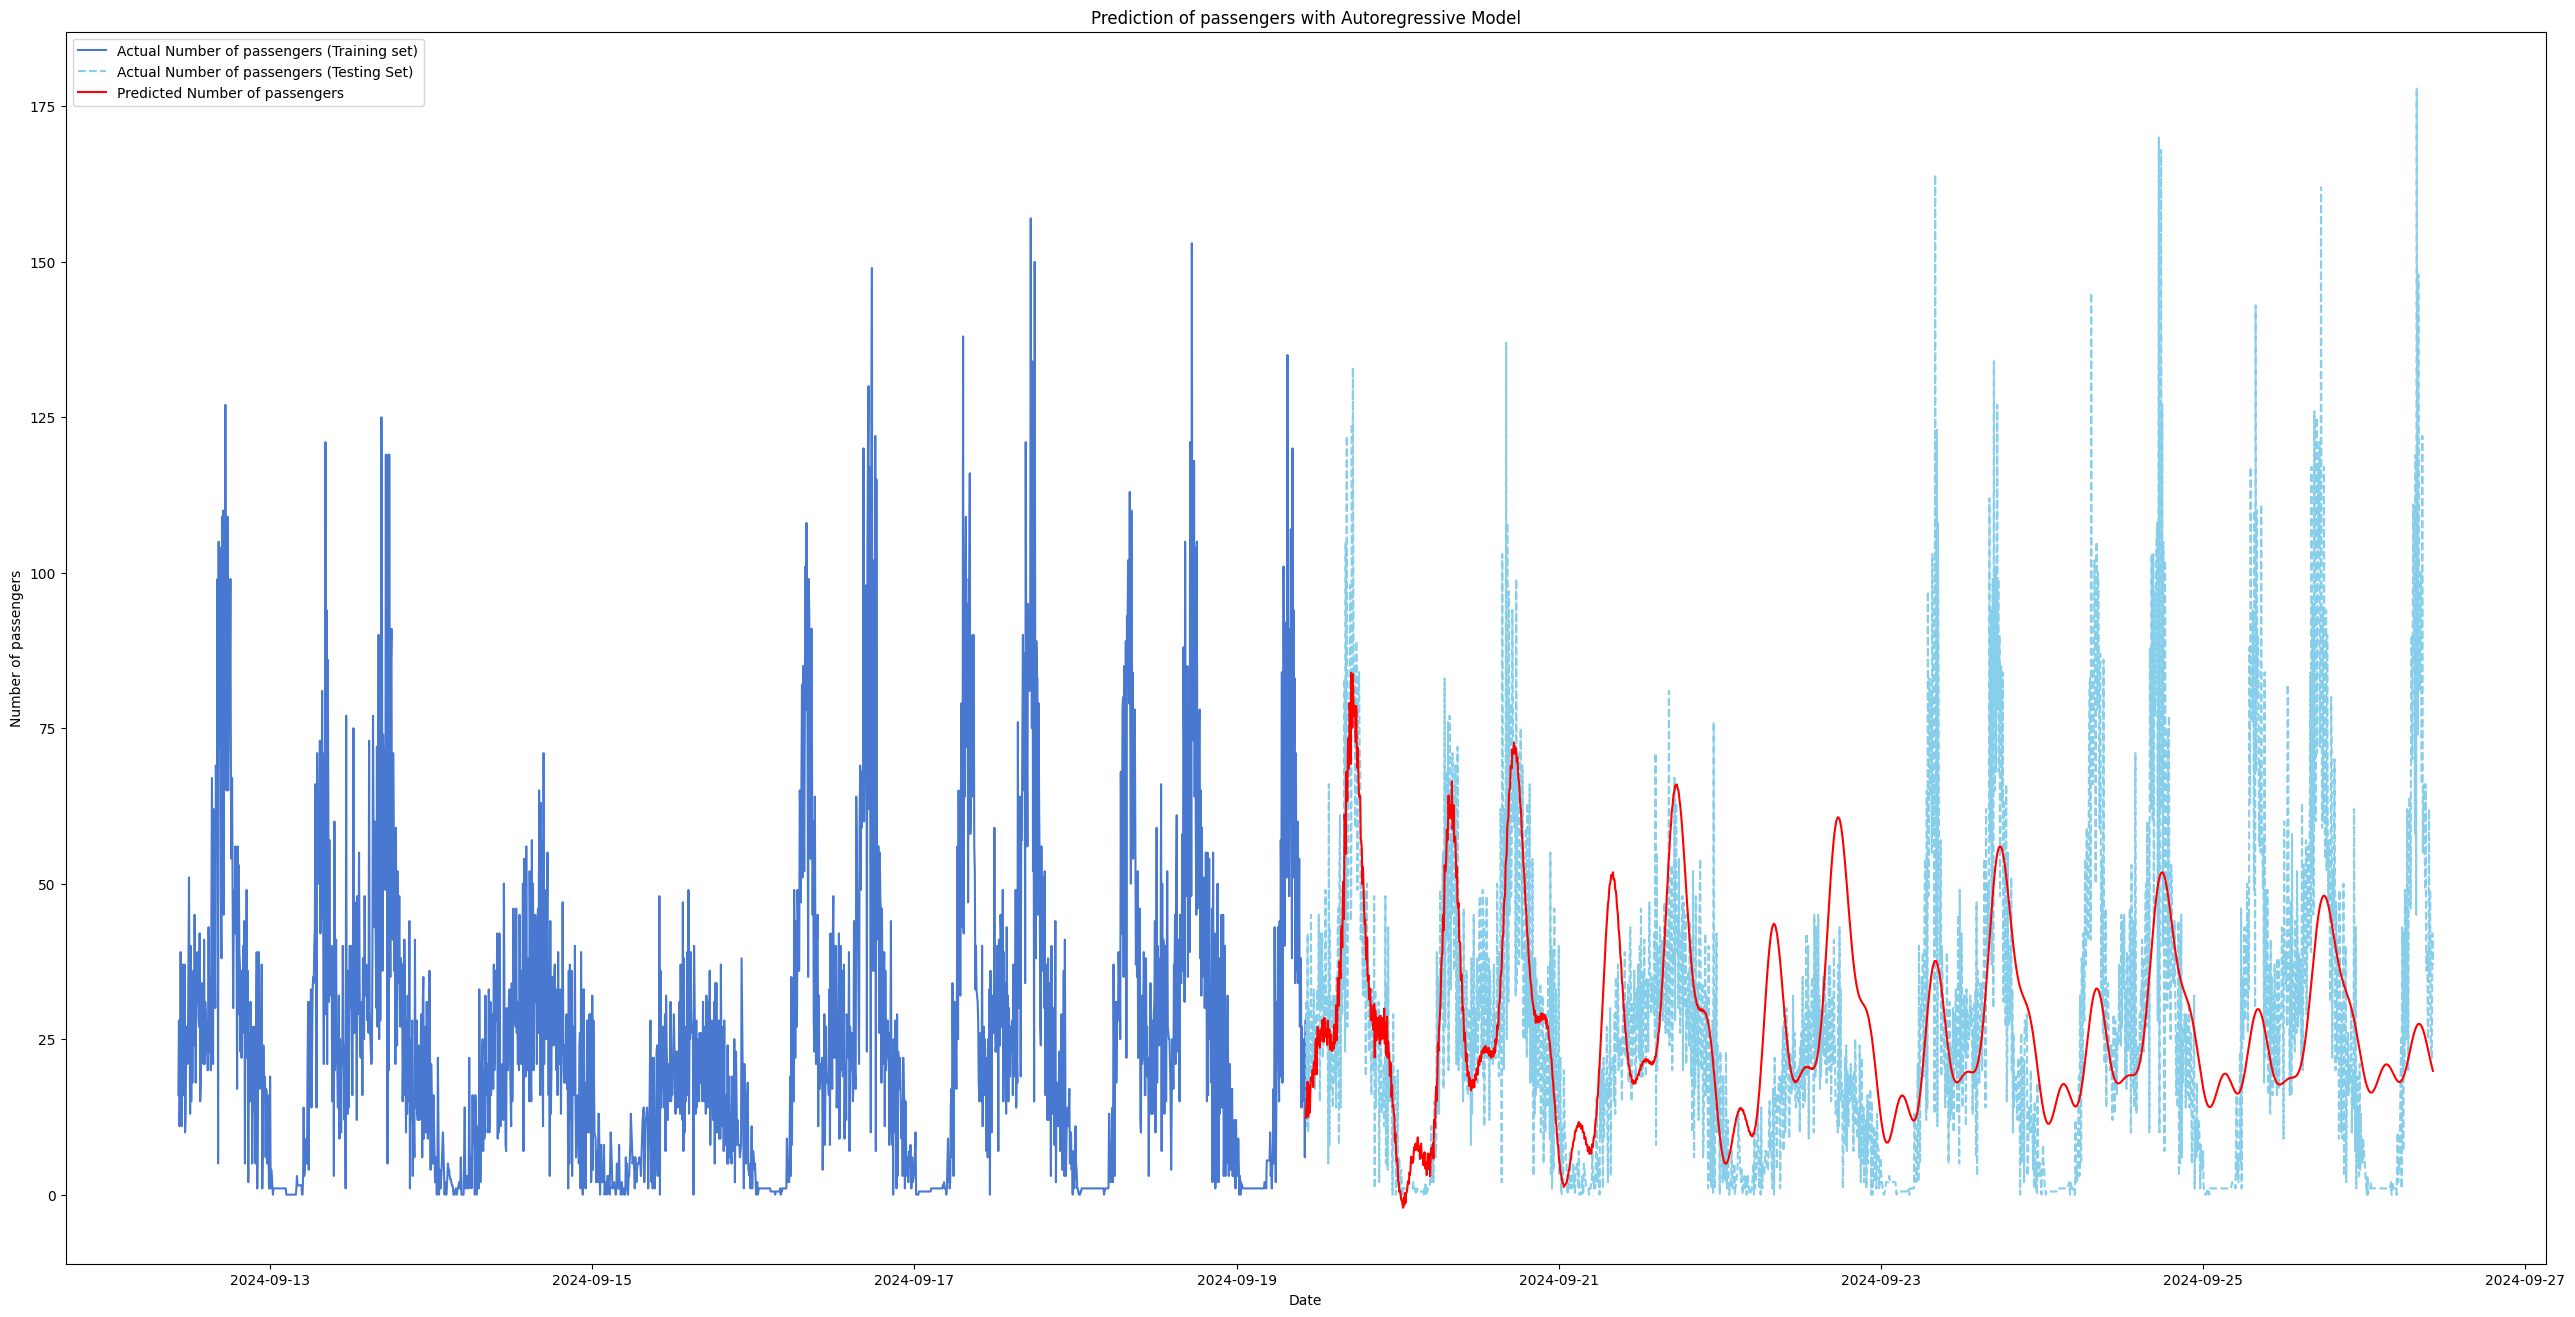

In [65]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps_ost = 7*day

# Extend the predictions into the future for one week
future_indices = range(len(test_ost), len(test_ost) + forecast_steps_ost)
# enter prediction date
future_predictions = results_ar_ost.predict(start=len(train_ost), end=len(train_ost) + len(test_ost) + forecast_steps_ost - 1)


# Plot the testing data, training data, and predictions on our testing data for one week
plt.figure(figsize=(32, 16))
plt.plot(train_ost["Timestamp"][len(train_ost)-forecast_steps_ost:],train_ost["Ost-VBZ Total"][len(train_ost)-forecast_steps_ost:], label = "Actual Number of passengers (Training set)")
plt.plot(test_ost["Timestamp"][:forecast_steps_ost],test_ost["Ost-VBZ Total"][:forecast_steps_ost], label='Actual Number of passengers (Testing Set)', linestyle = "--",color = "skyblue")
plt.plot(test_ost["Timestamp"][:forecast_steps_ost],y_pred_ost[:forecast_steps_ost], label='Predicted Number of passengers', color = "red")

plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Prediction of passengers with Autoregressive Model')
plt.show()

C:\Users\micha\AppData\Local\Temp\ipykernel_128568\3593924651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_ost["Timestamp"] = pd.to_datetime(test_ost["Timestamp"])
C:\Users\micha\AppData\Local\Temp\ipykernel_128568\3593924651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ost["Timestamp"] = pd.to_datetime(train_ost["Timestamp"])
C:\Users\micha\AppData\Local\Temp\ipykernel_128568\3593924651.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min

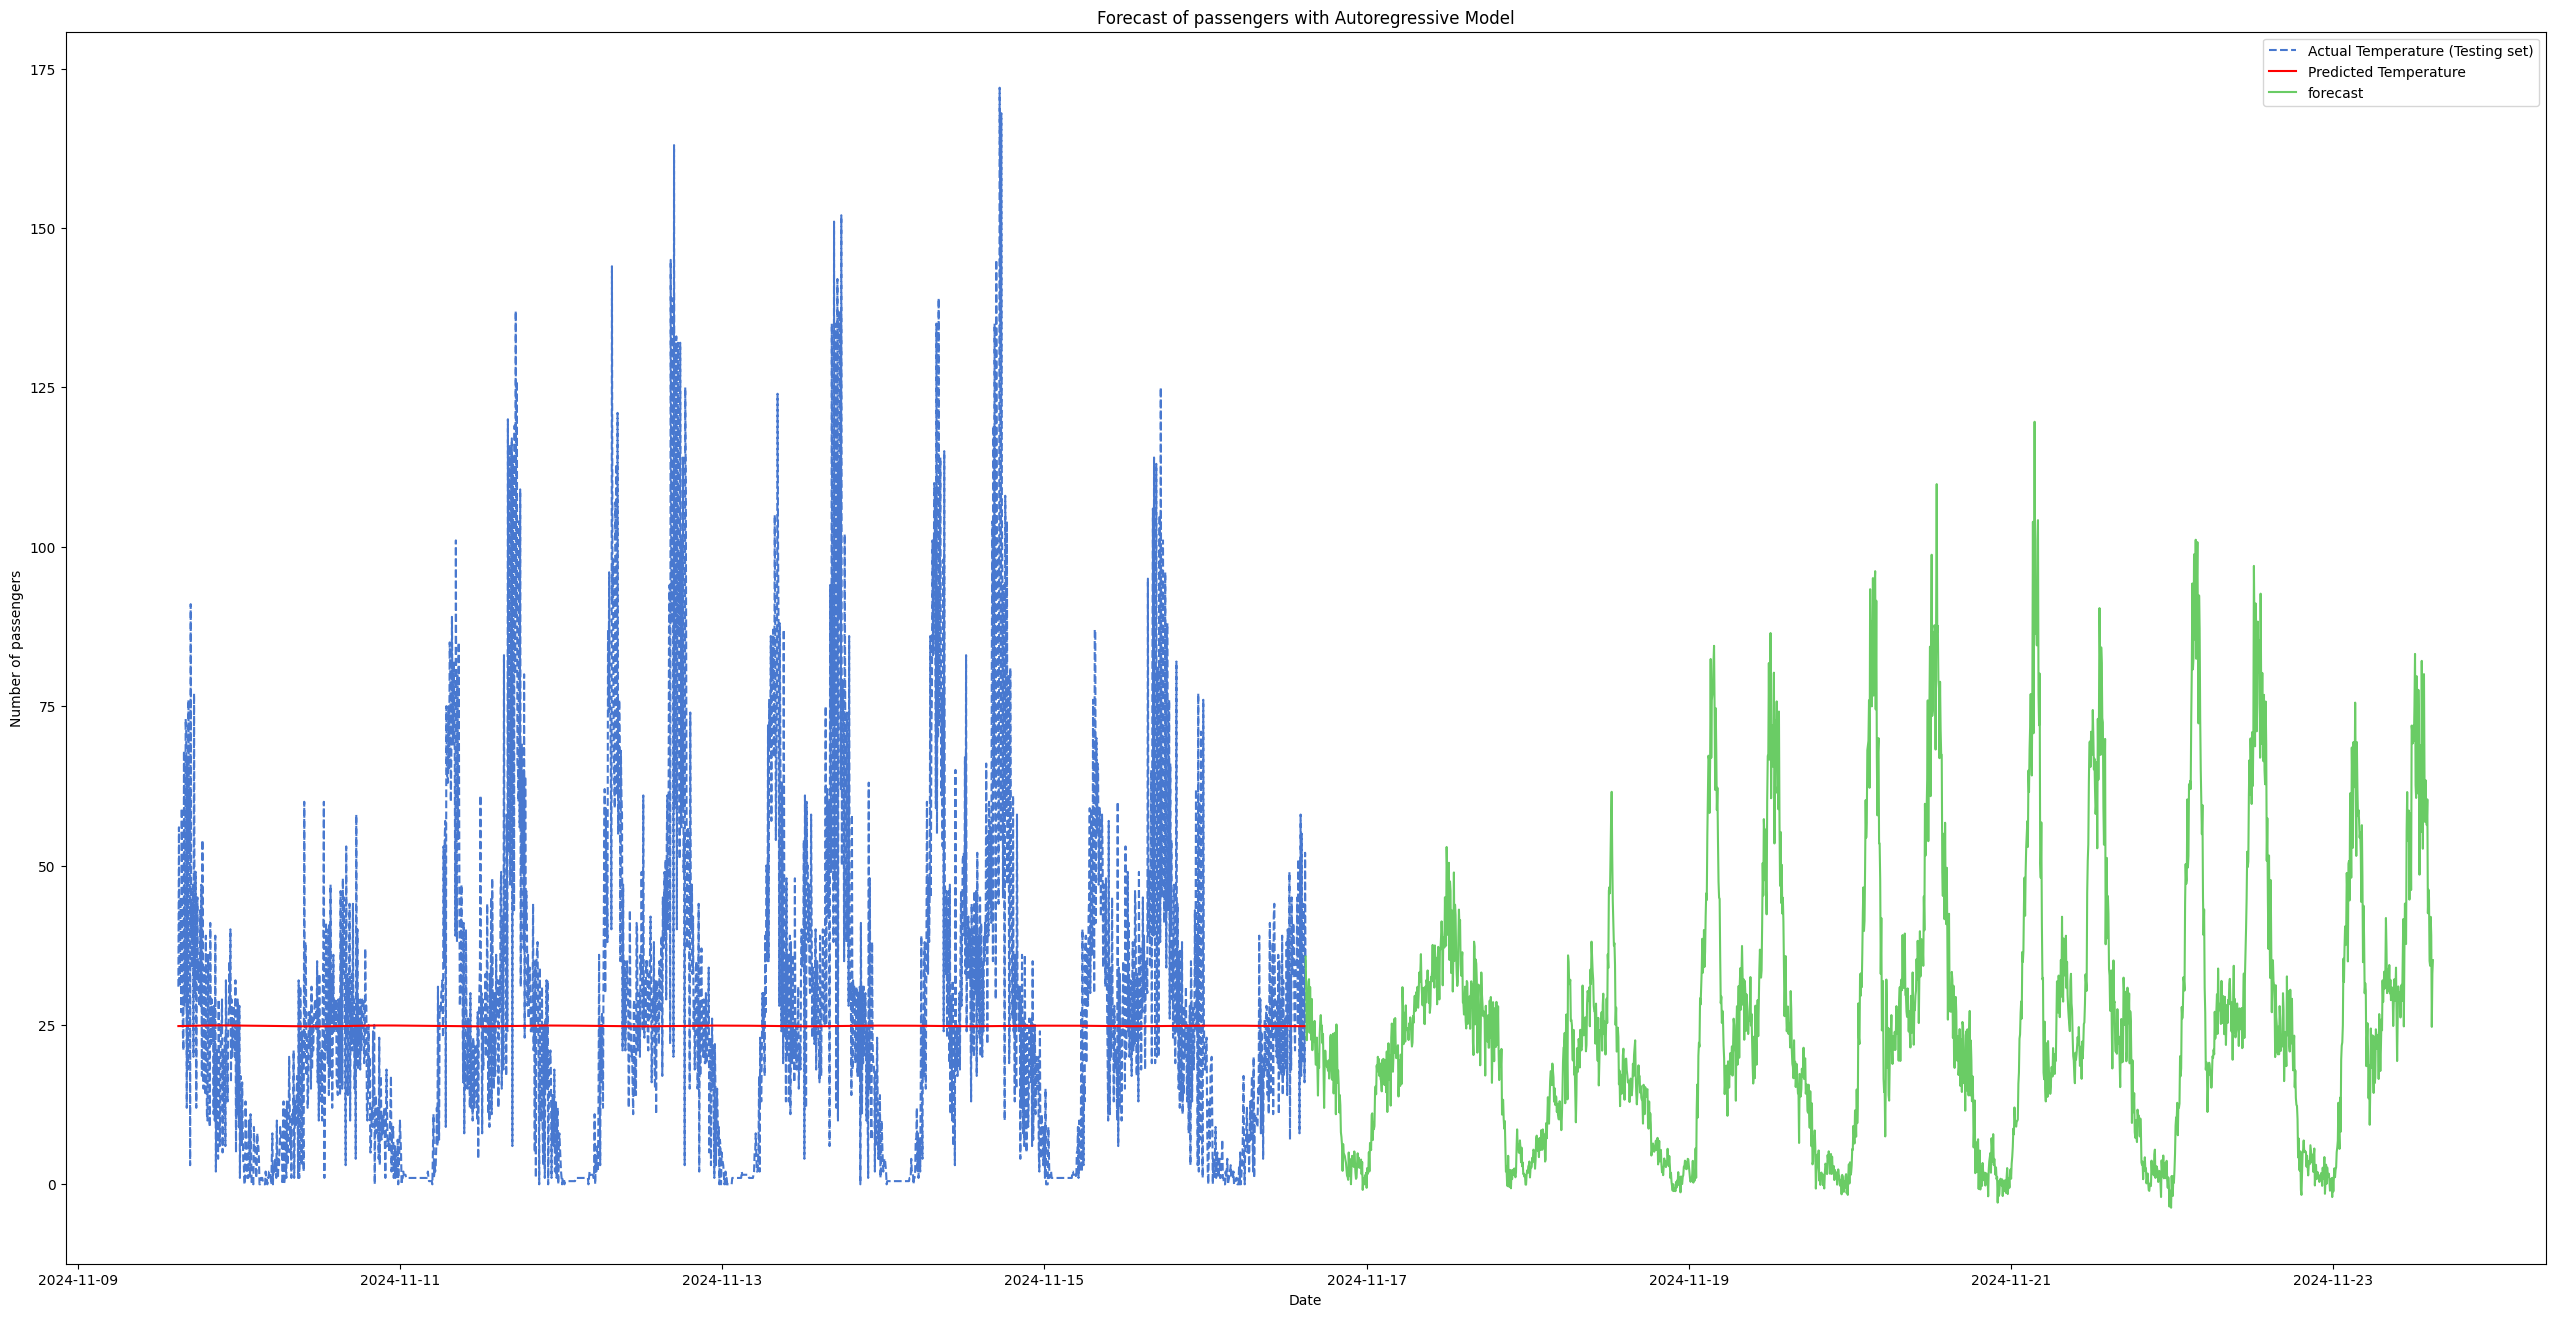

In [66]:
# Define the number of future time steps you want to predict (7 days)
forecast_steps_ost = 7*day
# convert stamp into datetime
test_ost["Timestamp"] = pd.to_datetime(test_ost["Timestamp"])
train_ost["Timestamp"] = pd.to_datetime(train_ost["Timestamp"])

# Extend the predictions into the future for one year 
future_indices_ost = range(len(test_ost), len(test_ost) + forecast_steps_ost)
future_predictions_ost = results_ar_ost.predict(start=len(test_ost), end=len(test_ost) + forecast_steps_ost - 1)
future_dates_ost = pd.date_range(start=test_ost["Timestamp"].iloc[-1], periods=forecast_steps_ost, freq='5T')

# Create date indices for the future predictions

# Plot the actual data in the testing set, predictions on the testing set, and one week of future predictions
plt.figure(figsize=(32, 16))
plt.plot(test_ost["Timestamp"][len(test_ost)-forecast_steps_ost:], test_ost["Ost-VBZ Total"][len(test_ost)-forecast_steps_ost:], label='Actual Temperature (Testing set)', linestyle = "--")
plt.plot(test_ost["Timestamp"][len(test_ost)-forecast_steps_ost:], y_pred_ost[len(test_ost)-forecast_steps_ost:], label='Predicted Temperature', color = "red")
plt.plot(future_dates_ost, future_predictions_ost[-forecast_steps_ost:], label ="forecast")
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Forecast of passengers with Autoregressive Model')
plt.show()

In [67]:
# Reproduce the model with the other side:
df_west_train = int(len(df_west)*0.808580858085808580858085808580858085808580858085)
train_west ,test_west = df_west[:df_west_train], df_west[df_west_train:]

from sklearn.model_selection import TimeSeriesSplit
# rolling windows
tscv = TimeSeriesSplit(n_splits=10)

len(train_west),len(test_west)

(70793, 16760)

In [68]:
# Create and train the autoregressive model
ar_model_west = AutoReg(train_west["West-VBZ total"], lags=lags)
results_ar_west = ar_model_west.fit()

In [69]:
# Make predictions on the test set
y_pred_west = results_ar_west.predict(start=len(train_west["West-VBZ total"]), end=len(train_west["West-VBZ total"]) + len(test_west["West-VBZ total"])-1)
#print(y_pred)
y_pred_west

70793     5.822704
70794    11.960278
70795    11.198371
70796     8.112063
70797     9.214315
           ...    
87548    11.381796
87549    11.385789
87550    11.389777
87551    11.393758
87552    11.397730
Length: 16760, dtype: float64

In [70]:
mae_west = mean_absolute_error(test_west["West-VBZ total"], y_pred_west)
rmse_west = mean_squared_error(test_west["West-VBZ total"], y_pred_west)
print(f'Mean Absolute Error: {mae_west:.2f}')
print(f'Root Mean Squared Error: {rmse_west:.2f}')

Mean Absolute Error: 9.42
Root Mean Squared Error: 197.88


In [71]:
forecast_steps_west = 288
f_west = test_west["Timestamp"][:forecast_steps_west]
f_west
g_west = f_west[70560+(9/24)*288]    
g_west

KeyError: 70668.0

C:\Users\USER\AppData\Local\Temp\ipykernel_14892\410346417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_west["Timestamp"] = pd.to_datetime(test_west["Timestamp"])
C:\Users\USER\AppData\Local\Temp\ipykernel_14892\410346417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_west["Timestamp"] = pd.to_datetime(train_west["Timestamp"])
C:\Users\USER\AppData\Local\Temp\ipykernel_14892\410346417.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' inst

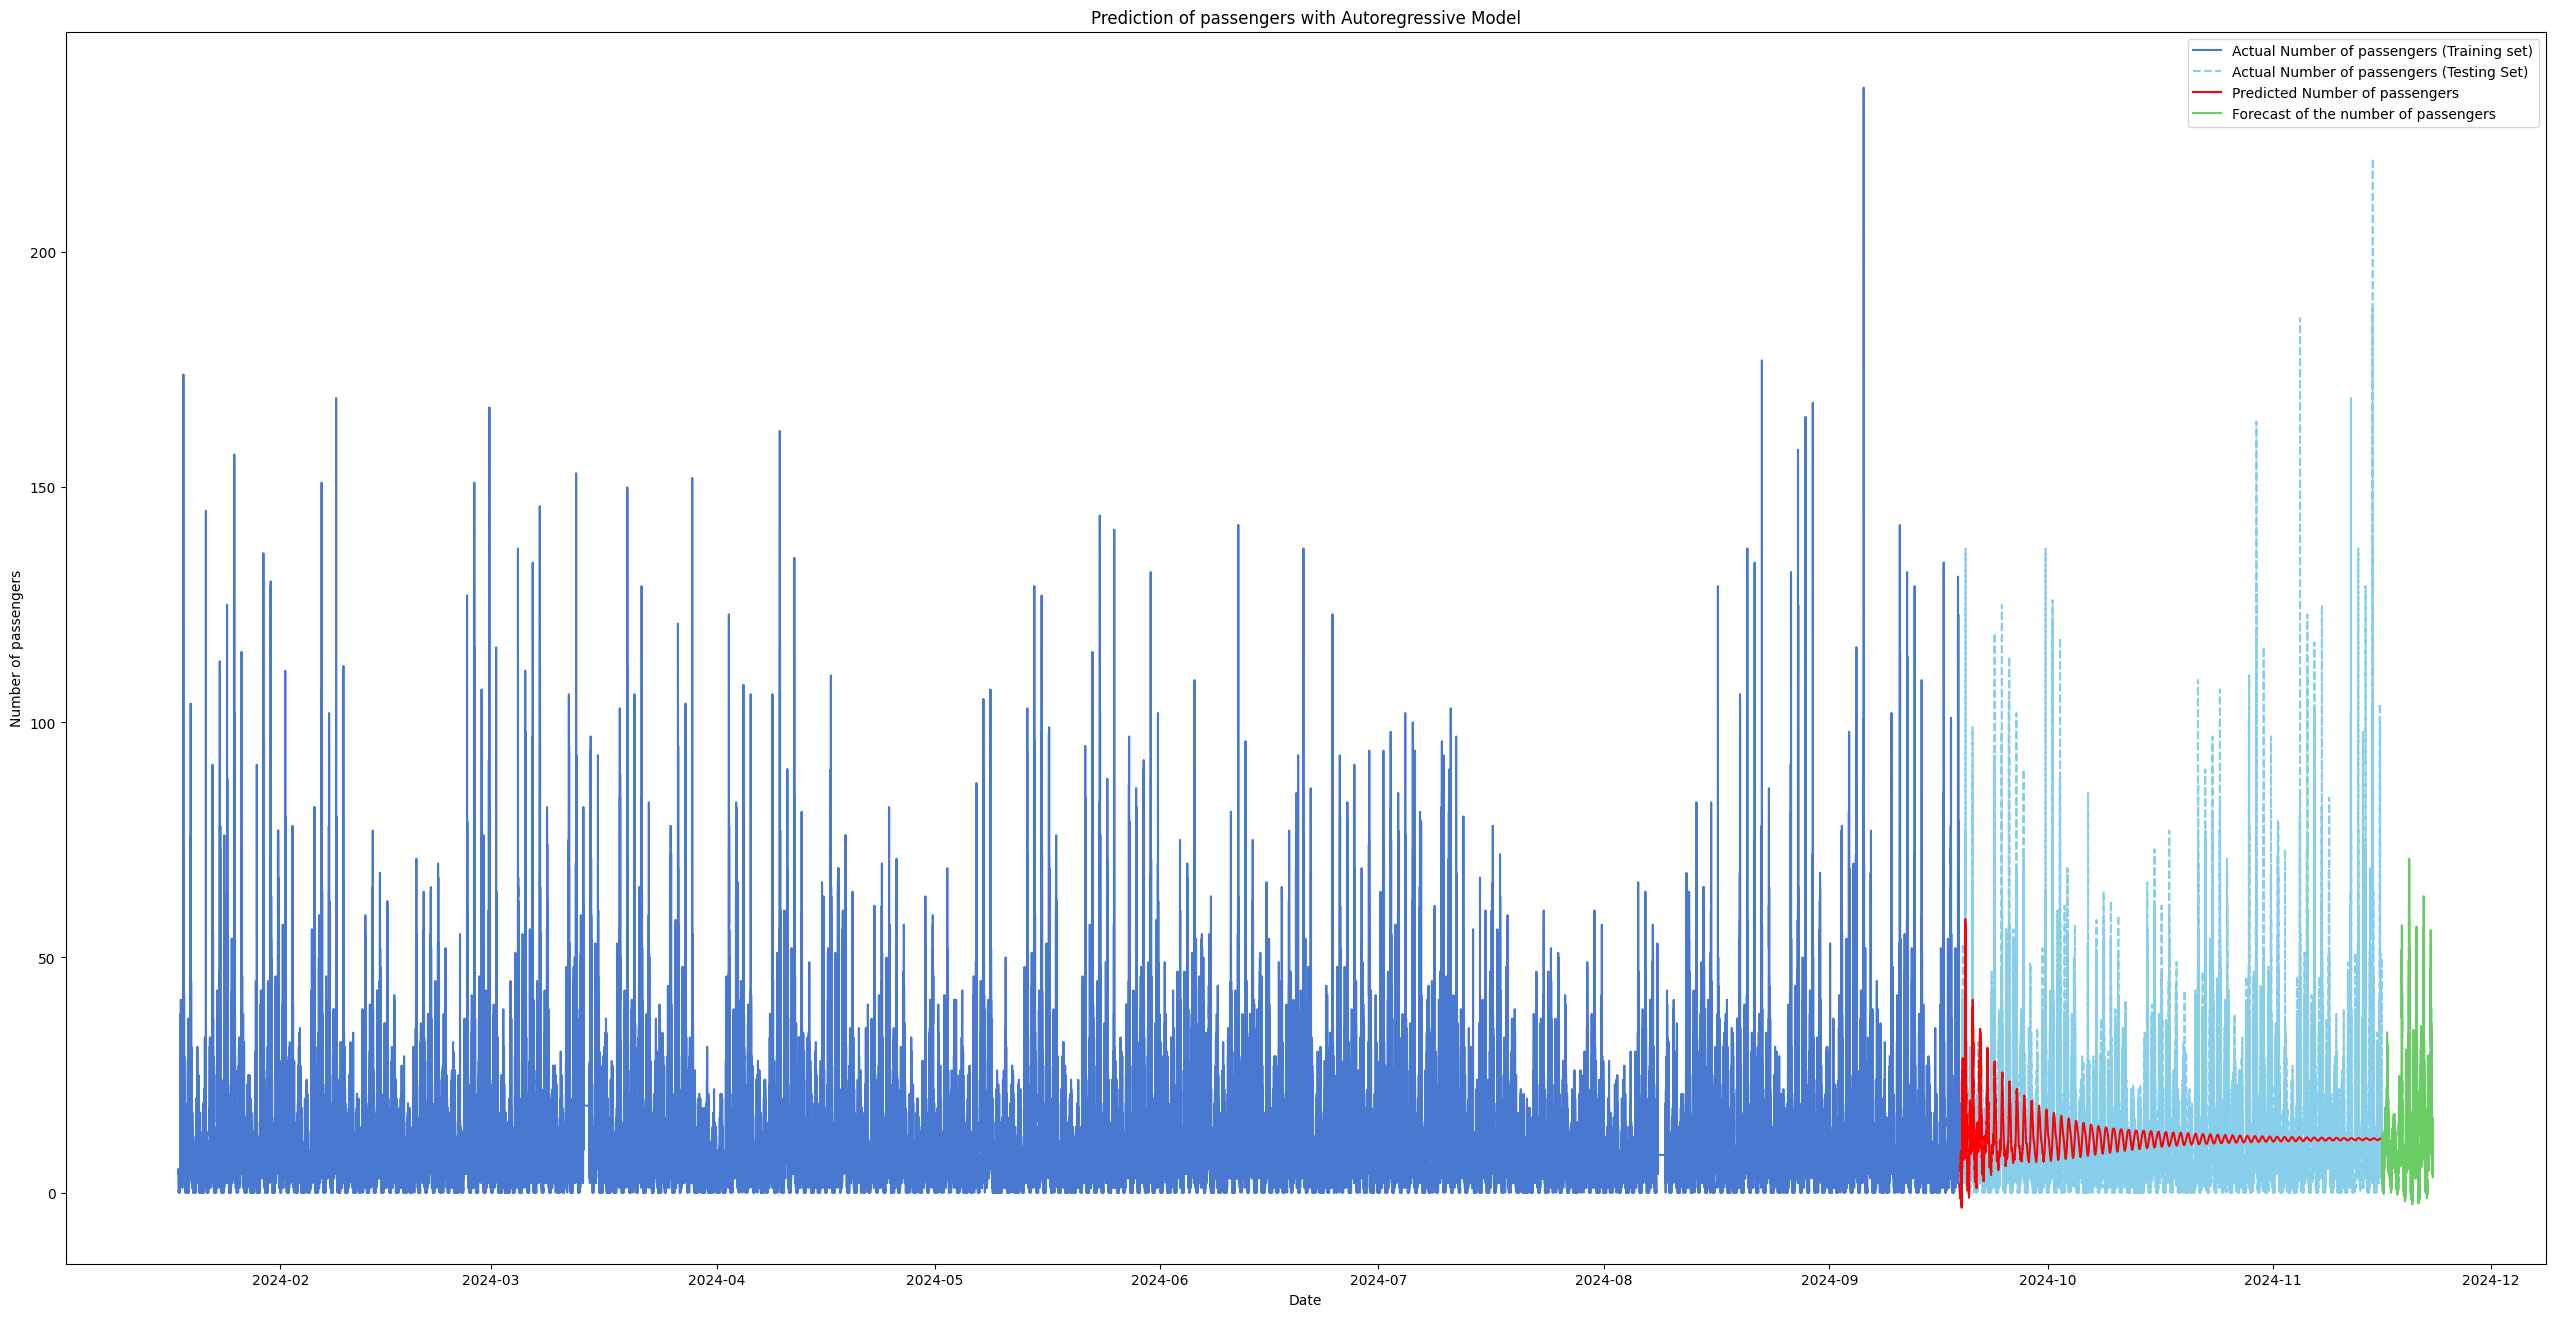

In [ ]:
day = 288
forecast_steps_west = 7*day
# convert stamp
test_west["Timestamp"] = pd.to_datetime(test_west["Timestamp"])
train_west["Timestamp"] = pd.to_datetime(train_west["Timestamp"])

#future_indices_ost = range(len(test_ost), len(test_ost) + forecast_steps_ost)
future_predictions_west = results_ar_west.predict(start=len(test_west), end=len(test_west) + forecast_steps_west - 1)
future_dates_west = pd.date_range(start=test_west["Timestamp"].iloc[-1], periods=forecast_steps_west, freq='5T')

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(32, 16))
plt.plot(train_west["Timestamp"],train_west["West-VBZ total"], label = "Actual Number of passengers (Training set)")
plt.plot(test_west["Timestamp"],test_west["West-VBZ total"], label='Actual Number of passengers (Testing Set)', linestyle = "--",color = "skyblue")
plt.plot(test_west["Timestamp"],y_pred_west, label='Predicted Number of passengers', color = "red")
plt.plot(future_dates_west, future_predictions_west, label = "Forecast of the number of passengers")

plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Prediction of passengers with Autoregressive Model')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14892\62001311.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates_west = pd.date_range(start=test_west["Timestamp"].iloc[-1], periods=forecast_steps_west, freq='5T')


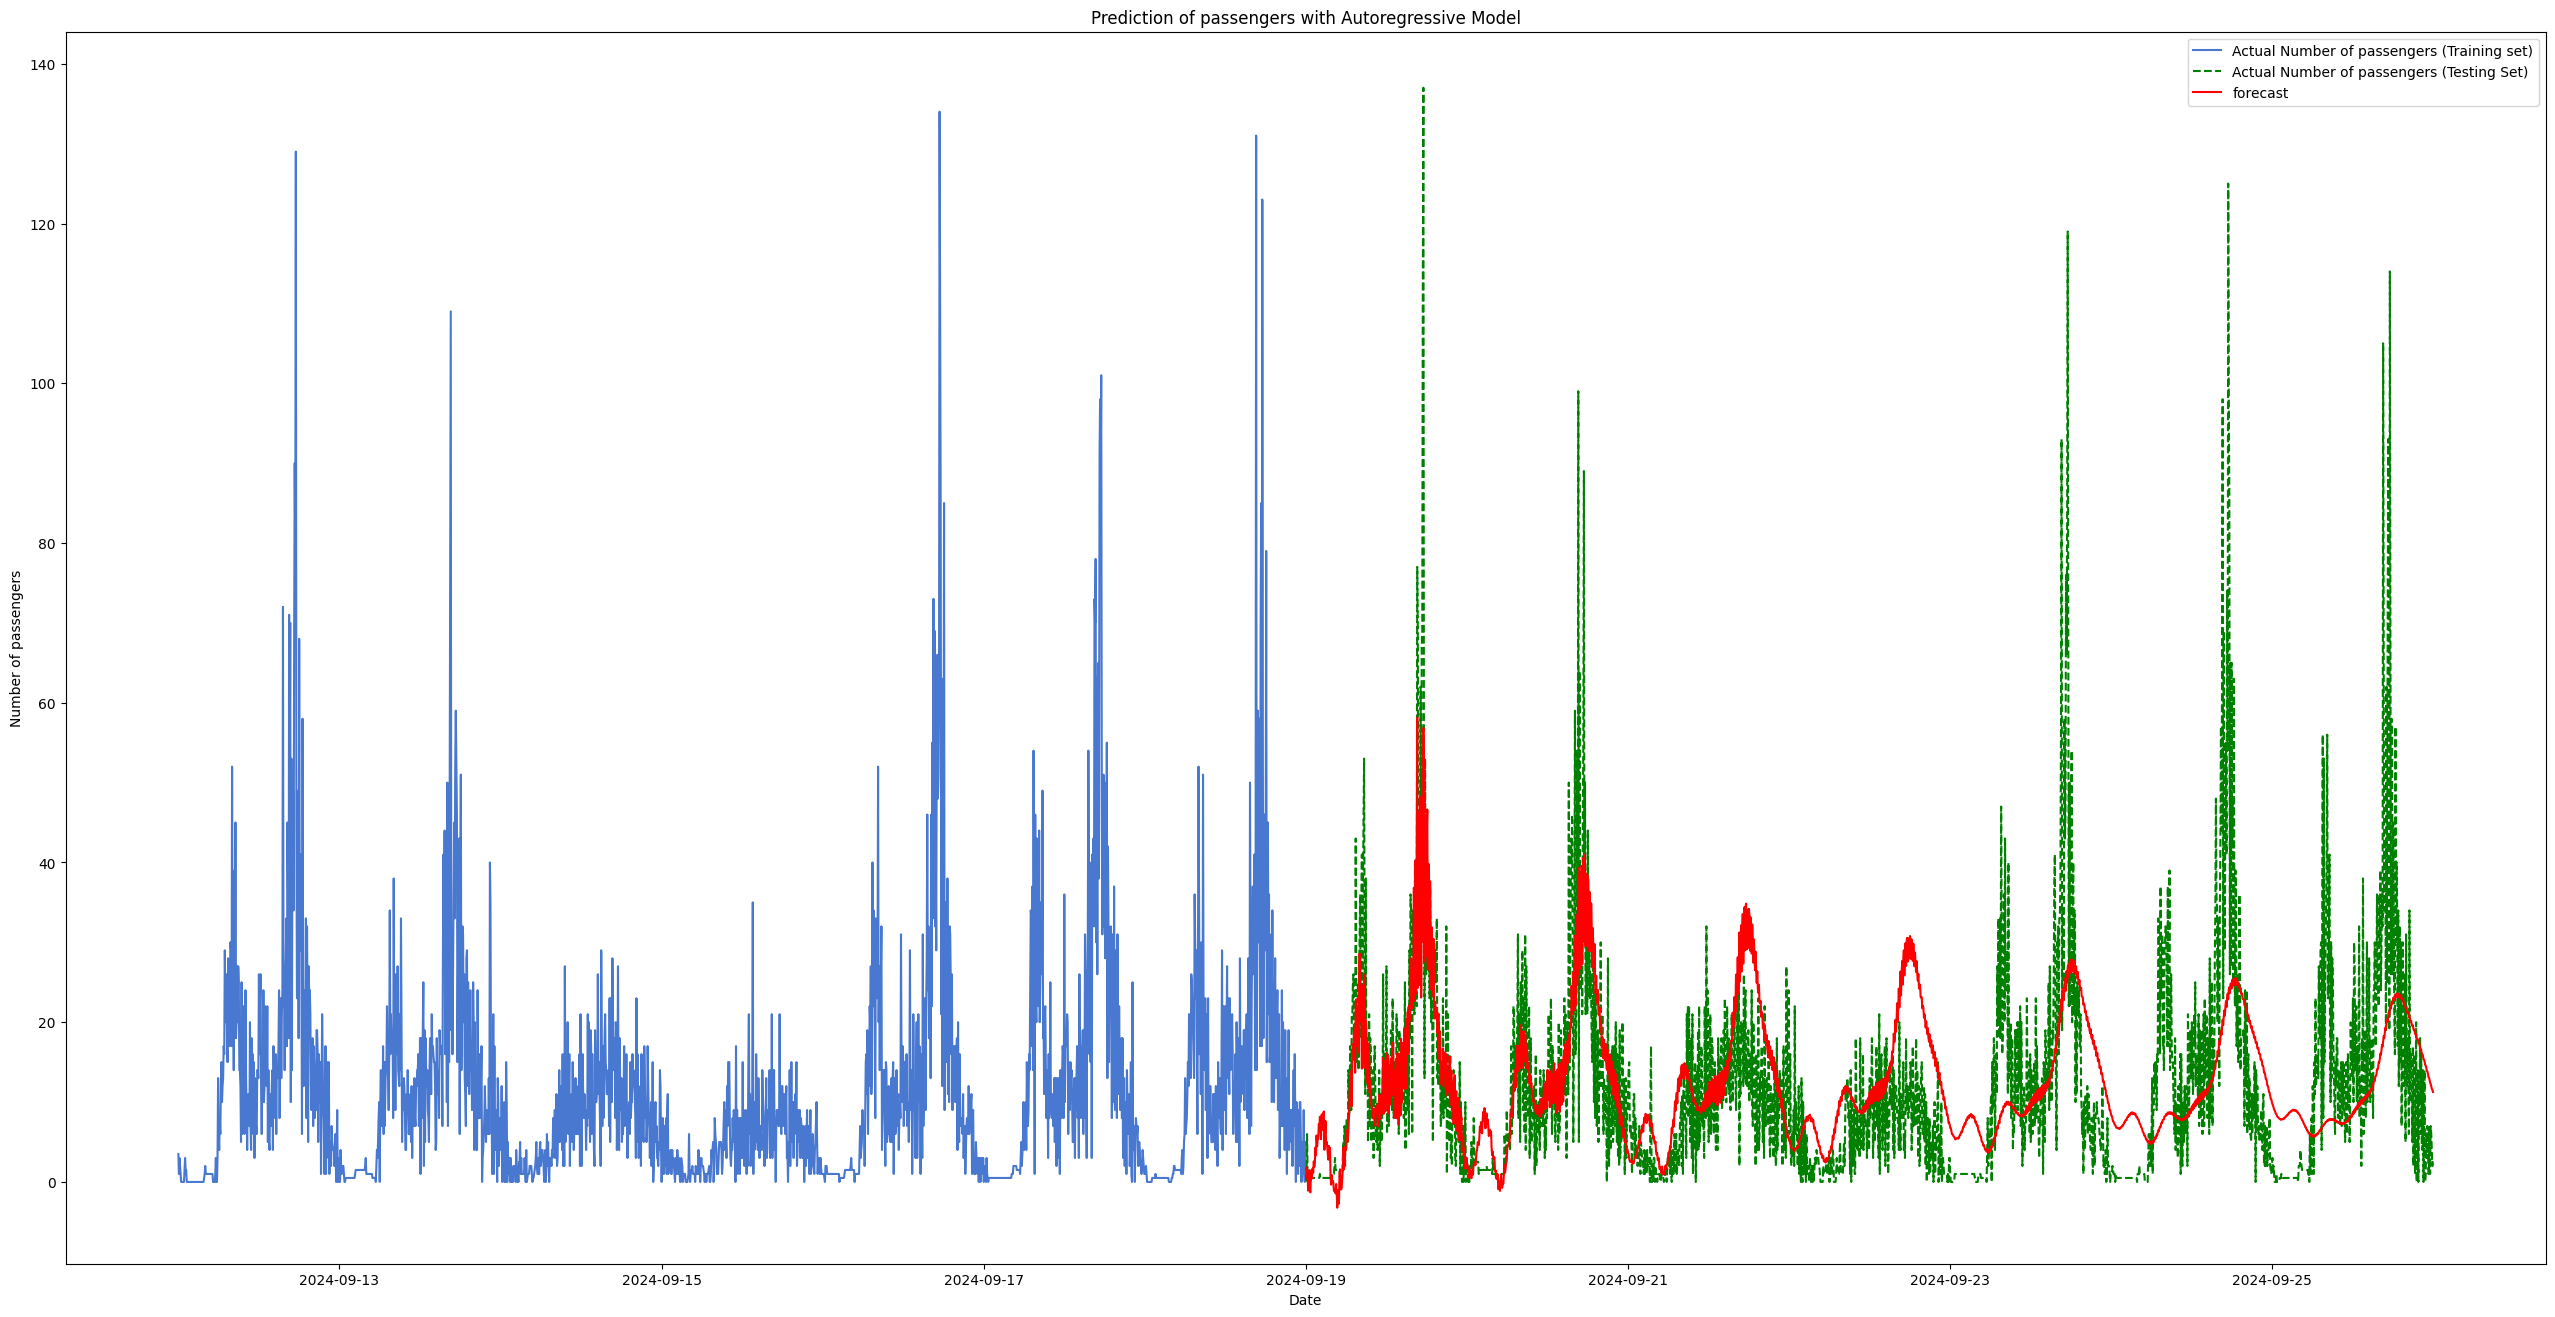

In [ ]:
# Define the number of future time steps you want to predict (1 week)

#future_indices_ost = range(len(test_ost), len(test_ost) + forecast_steps_ost)
future_predictions_west = results_ar_west.predict(start=len(test_west), end=len(test_west) + forecast_steps_west - 1)
future_dates_west = pd.date_range(start=test_west["Timestamp"].iloc[-1], periods=forecast_steps_west, freq='5T')

# Create date indices for the future predictions

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(32, 16))
plt.plot(train_west["Timestamp"][len(train_ost)-forecast_steps_west:],train_west["West-VBZ total"][len(train_west)-forecast_steps_west:], label = "Actual Number of passengers (Training set)")
plt.plot(test_west["Timestamp"][:forecast_steps_west],test_west["West-VBZ total"][:forecast_steps_west], label='Actual Number of passengers (Testing Set)', linestyle = "--",color = "green")
plt.plot(test_west["Timestamp"][:forecast_steps_west], y_pred_west[:forecast_steps_west], label ="forecast", color = "red")

plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Prediction of passengers with Autoregressive Model')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14892\2718219508.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_west["Timestamp"] = pd.to_datetime(test_west["Timestamp"])
C:\Users\USER\AppData\Local\Temp\ipykernel_14892\2718219508.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_west["Timestamp"] = pd.to_datetime(train_west["Timestamp"])
C:\Users\USER\AppData\Local\Temp\ipykernel_14892\2718219508.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' 

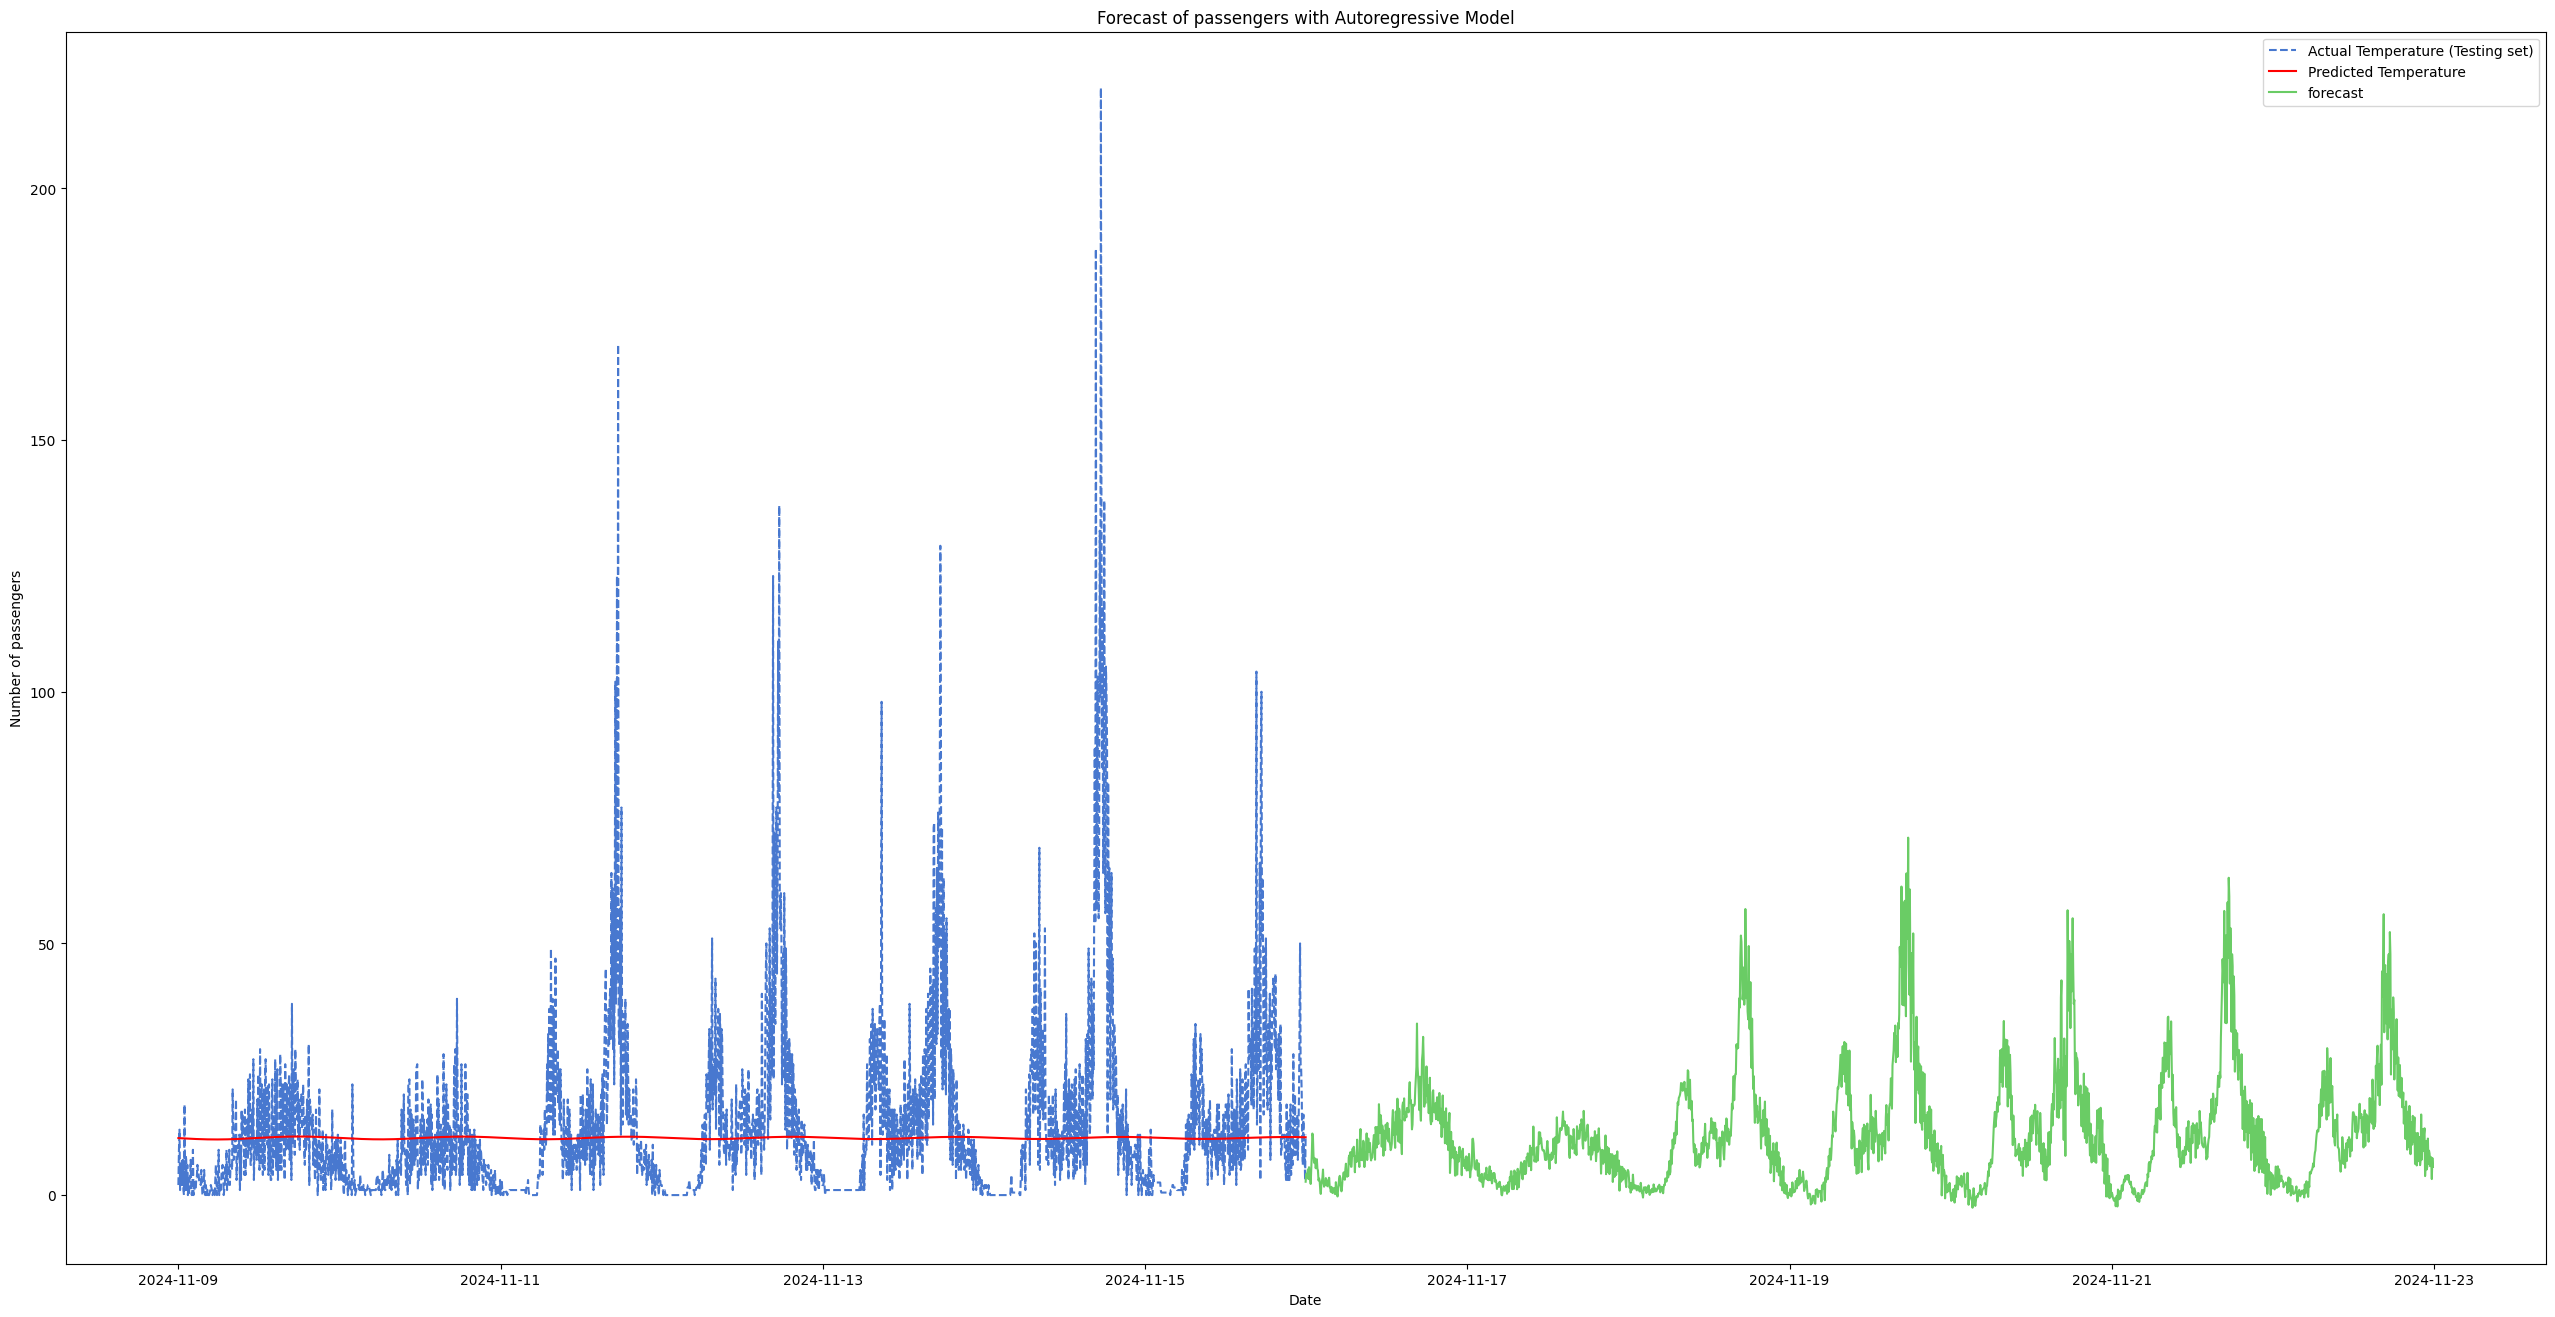

In [ ]:
# Define the number of future time steps you want to predict (1 day)
forecast_steps_west = 7*day
# convert stamp
test_west["Timestamp"] = pd.to_datetime(test_west["Timestamp"])
train_west["Timestamp"] = pd.to_datetime(train_west["Timestamp"])

# Extend the predictions into the future for one year
future_indices_west = range(len(test_west), len(test_west) + forecast_steps_west)
future_predictions_west = results_ar_west.predict(start=len(test_west), end=len(test_west) + forecast_steps_west - 1)
future_dates_west = pd.date_range(start=test_west["Timestamp"].iloc[-1], periods=forecast_steps_west, freq='5T')

# Create date indices for the future predictions

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(32, 16))
plt.plot(test_west["Timestamp"][len(test_west)-forecast_steps_west:], test_west["West-VBZ total"][len(test_west)-forecast_steps_west:], label='Actual Temperature (Testing set)', linestyle = "--")
plt.plot(test_west["Timestamp"][len(test_west)-forecast_steps_west:], y_pred_west[len(test_west)-forecast_steps_west:], label='Predicted Temperature', color = "red")
plt.plot(future_dates_west, future_predictions_west[-forecast_steps_west:], label ="forecast")
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.title('Forecast of passengers with Autoregressive Model')
plt.show()

# Modelling phase - Random Forest

To use our X Matrices in the models we need to exclude the timestamp variables as well as the y variable to prevent data leakage. Afterwards we define a threshhold for our cross validation split which was also used with our AR Model later on, in order to ensure the same splits. We also make shure to set shuffle to false with cross validation so the time is not mixed for our time series and no leakage is possible.

In [23]:

#Define Design matrix and outcome variables
y_ost = data_ost["Ost-VBZ Total"]
y_west = data_west["West-VBZ total"]

exclude_columns_ost = ["Timestamp", 
                       "Ost-VBZ Total" ,
                       "West-VBZ total"
                       ]
exclude_columns_west = ["Timestamp", 
                       "West-VBZ total",
                       "Ost-VBZ Total" 
                       ]

X_ost = data_ost.drop(columns = exclude_columns_ost)
X_west = data_west.drop(columns = exclude_columns_west)
#Split into training and test data 
from sklearn.model_selection import train_test_split

threshold_train = 0.808580858085808580858085808580858085808580858085
threshold_test = 1- threshold_train

X_ost_train, X_ost_test, y_ost_train, y_ost_test = train_test_split(X_ost, y_ost, shuffle = False, test_size = threshold_test)
X_west_train, X_west_test, y_west_train, y_west_test = train_test_split(X_west, y_west, shuffle = False, test_size = threshold_test)

In [24]:
X_ost_train

Holiday  t-1 Ost-VBZ  t-2 Ost-VBZ  t-3 Ost-VBZ  t-4 Ost-VBZ  \
397          0          4.0          5.5          7.0         13.0   
398          0          1.0          4.0          5.5          7.0   
399          0          3.5          1.0          4.0          5.5   
400          0          6.0          3.5          1.0          4.0   
401          0          2.0          6.0          3.5          1.0   
...        ...          ...          ...          ...          ...   
70952        0         11.0          3.0         17.0         10.0   
70953        0          3.0         11.0          3.0         17.0   
70954        0         12.0          3.0         11.0          3.0   
70955        0          8.0         12.0          3.0         11.0   
70956        0          1.0          8.0         12.0          3.0   

       t-5 Ost-VBZ  t-6 Ost-VBZ  t-7 Ost-VBZ  t-8 Ost-VBZ  t-9 Ost-VBZ  ...  \
397            2.0          5.0         12.0          9.0          7.0  ...   
398           13.0          2.0          5.0         12.0          9.0  ...   
399            7.0         13.0          2.0          5.0         12.0  ...   
400            5.5          7.0         13.0          2.0          5.0  ...   
401            4.0          5.5          7.0         13.0          2.0  ...   
...            ...          ...          ...          ...          ...  ...   
70952         12.0          4.0         21.0         13.0          3.0  ...   
70953         10.0         12.0          4.0         21.0         13.0  ...   
70954         17.0         10.0         12.0          4.0         21.0  ...   
70955          3.0         17.0         10.0         12.0          4.0  ...   
70956         11.0          3.0         17.0         10.0         12.0  ...   

       wind_speed_avg_10min  wind_force_avg_10min  wind_direction  windchill  \
397                     4.0                   4.0            55.0        6.0   
398                     4.0                   4.0            55.0        6.0   
399                     3.8                   3.8            50.0        6.1   
400                     3.8                   3.8            50.0        6.1   
401                     4.3                   4.3            63.0        5.8   
...                     ...                   ...             ...        ...   
70952                   1.2                   1.2           271.0       11.9   
70953                   1.3                   1.3           238.0       11.8   
70954                   1.3                   1.3           238.0       11.8   
70955                   0.6                   0.6           176.0       11.8   
70956                   0.6                   0.6           176.0       11.8   

       barometric_pressure_qfe  precipitation  dew_point  global_radiation  \
397                      947.7            0.1        7.3               0.0   
398                      947.7            0.1        7.3               0.0   
399                      947.6            0.0        7.3               0.0   
400                      947.6            0.0        7.3               0.0   
401                      947.6            0.1        7.2               0.0   
...                        ...            ...        ...               ...   
70952                    971.7            0.0       11.1               0.0   
70953                    971.6            0.0       11.0               0.0   
70954                    971.6            0.0       11.0               0.0   
70955                    971.7            0.0       11.1               0.0   
70956                    971.7            0.0       11.1               0.0   

       humidity  water_level  
397        86.0       405.83  
398        86.0       405.83  
399        86.0       405.84  
400        86.0       405.84  
401        87.0       405.84  
...         ...          ...  
70952      95.0       406.00  
70953      95.0       406.00  
70954      95.0       406.00  
70955    

### Predicting inflow of passengers in Ost

We train one simple variant of our random forest once to do a feature importance plot afterwards, which will allow us to get rid of unnecessary weather features.

In [25]:
#Import RandomForest Regressor
from sklearn.ensemble import RandomForestRegressor

RF_ost = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost.fit(X_ost_train, y_ost_train)

#Predict for train set
y_ost_predict_train = RF_ost.predict(X_ost_train)
y_ost_predict_test = RF_ost.predict(X_ost_test)

# Import the mean_squared_error function under the alias mse
from sklearn.metrics import mean_squared_error as mse

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test))

Ost Train MSE: 21.600256478617492
Ost Test MSE: 172.5005859524665


In [ ]:
RF_west = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest Regressor for West
RF_west.fit(X_west_train, y_west_train)

#Predict for train and test sets
y_west_predict_train = RF_west.predict(X_west_train)
y_west_predict_test = RF_west.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train))
print("West Test MSE:", mse(y_west_test, y_west_predict_test))

Text(0, 0.5, 'Predicted Value')

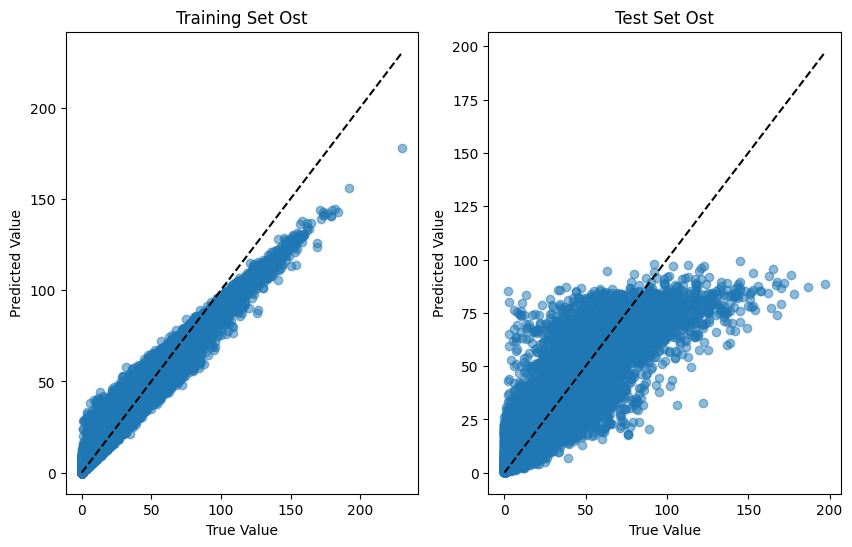

In [26]:
# Plot our predictions for Ost data
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data Ost
axs[0].scatter(y_ost_train, y_ost_predict_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_ost_train.min(), y_ost_predict_train.min()), 
               np.maximum(y_ost_train.max(), y_ost_predict_train.max())] for _ in range(2)],
              color = "black", ls="--")
axs[0].set_title("Training Set Ost")
axs[0].set_xlabel("True Value")
axs[0].set_ylabel("Predicted Value")

# Plot the test data Ost
axs[1].scatter(y_ost_test, y_ost_predict_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_ost_test.min(), y_ost_predict_test.min()), 
               np.maximum(y_ost_test.max(), y_ost_predict_test.max())] for _ in range(2)],
              color = "black", ls="--")
axs[1].set_title("Test Set Ost")
axs[1].set_xlabel("True Value")
axs[1].set_ylabel("Predicted Value")

### Feature Importance Plot to assess which variables should be droped


In [27]:
def plot_variable_importance(model, X_train):
    # Create a DataFrame with the feature importance of the model
    imp = pd.DataFrame({"imp": model.feature_importances_, "names": X_train.columns}).sort_values(by="imp", ascending=True)
    fig, ax = plt.subplots(figsize= (imp.shape[0]/6,imp.shape[0]/5), dpi = 300)
    
    
    # Plot the feature importance
    ax.barh(imp["names"], imp["imp"], color = "skyblue")
    ax.set_xlabel("\nFeature Importance")
    ax.set_ylabel("Features\n")
    ax.set_title("Variable Importance\n")
    plt.show()
    

We can see that after windchill there is a high drop off in variable importance, thus we cut of the variables which are below. We keep the t- variables even tough they explain the data less than some weather variables as to keep the seasonality and equidistance in tact. The above ones have a pretty high importance. Especially global_radiation which makes sense, as with more sun people tend to go outside more often. Precipitation could be so low, because the people have no alternative to taking public transport even though its raining. Maybe commuting by bike is just not an option in zürich. We also dropped barometric pressure and the dew point, as even though they hat some explaining information we think that this is due to chance and might lead to worse predictions on the test set. 

In [28]:
plot_variable_importance(RF_ost, X_ost_train)

In [99]:
#See with numbers how important each feature is and drop only weather features
importance = pd.DataFrame({"imp": RF_ost.feature_importances_, "names": X_ost_train.columns}).sort_values(by="imp", ascending=True)
drop = importance[importance["imp"] < 0.00115]
drop_list_ost = drop["names"].to_list()

#importance = pd.DataFrame({"imp": RF_west.feature_importances_, "names": X_west_train.columns}).sort_values(by="imp", ascending=True)
#importance[importance["imp"] < 0.0010]
#drop = importance[importance["imp"] < 0.010]
#drop_list_west = drop["names"].to_list()

drop_list_ost = [feature for feature in drop_list_ost if feature in weather.columns]
drop_list_ost
importance_ranked = importance[importance["names"].isin(weather.columns)].sort_values(by="imp", ascending=False)
importance_ranked.rename(columns = {"names": "Weather Features", "imp": "Importance"}, inplace = True)
importance_ranked["Importance"] = importance_ranked["Importance"].round(6)
importance_ranked.reset_index(drop = True, inplace = True)
importance_ranked

Importance         Weather Features
0     0.006764         global_radiation
1     0.001188          air_temperature
2     0.001181  barometric_pressure_qfe
3     0.001168                windchill
4     0.001156                dew_point
5     0.001102                 humidity
6     0.001084           wind_direction
7     0.001037        water_temperature
8     0.001011      wind_gust_max_10min
9     0.000992              water_level
10    0.000969     wind_force_avg_10min
11    0.000912     wind_speed_avg_10min
12    0.000189            precipitation

We define the columns which we want to keep because they showed good performance in the feature importance plot. All other weather features will be dropped.

In [31]:
#Drop columns below
drop_list_ost = weather.columns.drop(["air_temperature", "windchill", "global_radiation", "Timestamp"])
print(drop_list_ost)

drop_list_west = weather.columns.drop(["air_temperature", "windchill", "global_radiation", "Timestamp"])
print(drop_list_west)

Index(['water_temperature', 'wind_gust_max_10min', 'wind_speed_avg_10min',
       'wind_force_avg_10min', 'wind_direction', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'humidity', 'water_level'],
      dtype='object')
Index(['water_temperature', 'wind_gust_max_10min', 'wind_speed_avg_10min',
       'wind_force_avg_10min', 'wind_direction', 'barometric_pressure_qfe',
       'precipitation', 'dew_point', 'humidity', 'water_level'],
      dtype='object')


In [37]:
#Trim weather features
y_ost = data_ost["Ost-VBZ Total"]
y_west = data_west["West-VBZ total"]


X_ost_train_reduced = X_ost_train.drop(columns = drop_list_ost)
X_west_train_reduced = X_west_train.drop(columns = drop_list_west)

X_ost_test_reduced = X_ost_test.drop(columns = drop_list_ost)
X_west_test_reduced = X_west_test.drop(columns = drop_list_west)


In [38]:
X_west_train_reduced
X_ost_test_reduced

Holiday  t-1 Ost-VBZ  t-2 Ost-VBZ  t-3 Ost-VBZ  t-4 Ost-VBZ  \
70957        0         12.0          1.0          8.0         12.0   
70958        0          6.0         12.0          1.0          8.0   
70959        0          4.5          6.0         12.0          1.0   
70960        0          3.0          4.5          6.0         12.0   
70961        0          9.0          3.0          4.5          6.0   
...        ...          ...          ...          ...          ...   
87656        0          5.0         26.0         71.0         35.0   
87657        0          1.0          5.0         26.0         71.0   
87658        0         76.0          1.0          5.0         26.0   
87659        0         26.0         76.0          1.0          5.0   
87660        0         21.0         26.0         76.0          1.0   

       t-5 Ost-VBZ  t-6 Ost-VBZ  t-7 Ost-VBZ  t-8 Ost-VBZ  t-9 Ost-VBZ  ...  \
70957          3.0         11.0          3.0         17.0         10.0  ...   
70958         12.0          3.0         11.0          3.0         17.0  ...   
70959          8.0         12.0          3.0         11.0          3.0  ...   
70960          1.0          8.0         12.0          3.0         11.0  ...   
70961         12.0          1.0          8.0         12.0          3.0  ...   
...            ...          ...          ...          ...          ...  ...   
87656          7.0         60.0          2.0         77.0          3.0  ...   
87657         35.0          7.0         60.0          2.0         77.0  ...   
87658         71.0         35.0          7.0         60.0          2.0  ...   
87659         26.0         71.0         35.0          7.0         60.0  ...   
87660          5.0         26.0         71.0         35.0          7.0  ...   

       t-282 Ost-VBZ  t-283 Ost-VBZ  t-284 Ost-VBZ  t-285 Ost-VBZ  \
70957            0.0            0.5            1.0            1.0   
70958            0.0            0.0            0.5            1.0   
70959            0.0            0.0            0.0            0.5   
70960            0.5            0.0            0.0            0.0   
70961            0.5            0.5            0.0            0.0   
...              ...            ...            ...            ...   
87656            1.0            8.0            9.0            3.0   
87657           15.0            1.0            8.0            9.0   
87658            0.0           15.0            1.0            8.0   
87659            0.0            0.0           15.0            1.0   
87660            0.0            0.0            0.0           15.0   

       t-286 Ost-VBZ  t-287 Ost-VBZ  t-288 Ost-VBZ  air_temperature  \
70957            4.0            5.0           11.0             11.9   
70958            1.0            4.0            5.0             11.9   
70959            1.0            1.0            4.0             12.0   
70960            0.5            1.0            1.0             12.0   
70961            0.0            0.5            1.0             11.8   
...              ...            ...            ...              ...   
87656            7.0            8.0           11.0              1.8   
87657            3.0            7.0            8.0              2.1   
87658            9.0            3.0            7.0              2.1   
87659            8.0            9.0            3.0              2.1   
87660            1.0            8.0            9.0              2.1   

       windchill  global_radiation  
70957       11.9               0.0  
70958       11.9               0.0  
70959       12.0               0.0  
70960       12.0               0.0  
70961       11.8               0.0  
...          ...               ...  
87656        1.8               0.0  
87657        2.1               0.0  
87658        2.1               0.0  
87659        2.1               0.0  
87660        2.1               0.0  

[16704 rows x 292 columns]

### Performance of reduced model

We test the performance of the model with the reduced feature set once to see how it performs in comparison to the complete one. 

In [39]:
RF_ost_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_ost_reduced.fit(X_ost_train_reduced, y_ost_train)

#Predict for train set
y_ost_predict_train_reduced = RF_ost_reduced.predict(X_ost_train_reduced)
y_ost_predict_test_reduced = RF_ost_reduced.predict(X_ost_test_reduced)



#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_predict_train_reduced))
print("Ost Test MSE:", mse(y_ost_test, y_ost_predict_test_reduced))

Ost Train MSE: 21.5576418254854
Ost Test MSE: 172.77266323335724


In [ ]:
RF_west_reduced = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72 )

#Train RandomForest Regressor for Ost 
RF_west_reduced.fit(X_west_train_reduced, y_west_train)

#Predict for train set
y_west_predict_train_reduced = RF_west_reduced.predict(X_west_train_reduced)
y_west_predict_test_reduced = RF_west_reduced.predict(X_west_test_reduced)



#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_predict_train_reduced))
print("West Test MSE:", mse(y_west_test, y_west_predict_test_reduced))

We can see that the reduced set is almost the same as the full set. Thus we choose the simpler model to prevent potential overfitting in the future

### Performance of the RandomForest
Letting a RandomForest algorithm run withough tuning any parameter leads to estimations that might not be too accurate. 
- For the Bus Stop Hardbruecke with direction Schiffbau (Ost) the RandomForest performs somewhat decently (MSE = 25,6) in the trainset but very poorly in the test set (MSE = 206,14).
- FOR THE Bus Stop Hardbruecke with direction with direction Hardplatz the RandomForest performs far better. The MSE for the predictions on the Training set is 9,51 and for the Test set is about 82,27.

In both cases, the MSE is severely higher for the Testset, hinting towards an overfitting of the model. We can tune the hyperparamters of the model to try achieve a better estimate.

In [ ]:
# Plot our predictions for Ost data
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data Ost
axs[0].scatter(y_ost_train, y_ost_predict_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_ost_train.min(), y_ost_predict_train.min()), 
               np.maximum(y_ost_train.max(), y_ost_predict_train.max())] for _ in range(2)],
              color = "black", ls="--")
axs[0].set_title("Training Set Ost")

# Plot the test data Ost
axs[1].scatter(y_ost_test, y_ost_predict_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_ost_test.min(), y_ost_predict_test.min()), 
               np.maximum(y_ost_test.max(), y_ost_predict_test.max())] for _ in range(2)],
              color = "black", ls="--")
axs[1].set_title("Test Set Ost")

### Hyperparameter tuning of the RandomForest

In [ ]:
 # Run random forest again by setting max_feature = "sqrt"
RF_ost_t = RandomForestRegressor(n_estimators = 500, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for Ost
RF_ost_t.fit(X_ost_train, y_ost_train)

#Predict for train and test set
y_ost_pred_train = RF_ost_t.predict(X_ost_train)
y_ost_pred_test = RF_ost_t.predict(X_ost_test)

#Show MSE
print("Ost Train MSE:", mse(y_ost_train, y_ost_pred_train))
print("Ost Test MSE:", mse(y_ost_test, y_ost_pred_test))

In [ ]:
RF_west_t = RandomForestRegressor(n_estimators = 200, max_features = "sqrt", random_state = 72)

#Train RandomForest on Training Set for west
RF_west_t.fit(X_west_train, y_west_train)

#Preidct for train and test sets
y_west_pred_train = RF_west_t.predict(X_west_train)
y_west_pred_test = RF_west_t.predict(X_west_test)

#Show MSE
print("West Train MSE:", mse(y_west_train, y_west_pred_train))
print("West Test MSE:", mse(y_west_test, y_west_pred_test))

In [ ]:
hallo = X_ost_train.copy()

hallo.insert(0, "Mamamialol", y_west_train)
X_west_train
X_ost_train[:1]
X_ost_train.iloc[:, 287]





# Prediction weather data for random forest

Below we created an AR model to predict our weather features one day into the future. This was needed to be ablte to implement it into our nested random forest abomodel which will be introduced further below, as to not rely on third partie data sources. 

In [ ]:
df_global_radiation = X_ost['global_radiation']
df_windchill = X_ost['windchill']
df_air_temperature = X_ost['air_temperature']
#Test for stationery

from statsmodels.tsa.stattools import adfuller


result_global_radiation = adfuller(df_global_radiation)  
print("Global Radiation ADF Statistic:", result_global_radiation[0])
print("Global Radiation p-value:", result_global_radiation[1])
print("Global Radiation Critical Values:", result_global_radiation[4])

result_windchill = adfuller(df_windchill) 
print("Windchill ADF Statistic:", result_windchill[0])
print("Windchill p-value:", result_windchill[1])
print("Windchill Critical Values:", result_windchill[4])

result_air_temperature = adfuller(df_air_temperature)  
print("Air Temperature ADF Statistic:", result_air_temperature[0])
print("Air Temperature p-value:", result_air_temperature[1])
print("Air Temperature Critical Values:", result_air_temperature[4])

# Return the results


In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.tsa.stattools import acf

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

In [ ]:
plot_acf(df_global_radiation, lags = 1000)
plot_pacf(df_global_radiation, lags = 1000)

In [ ]:
plot_acf(df_windchill, lags = 1000)
plot_pacf(df_windchill, lags = 1000)

In [ ]:
plot_acf(df_air_temperature, lags = 1000)
plot_pacf(df_air_temperature, lags = 1000)

In [ ]:
# für temperature
# use AR Model for all
import sklearn.metrics
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_air_temperature_train = int(len(df_air_temperature)*0.8)
df_air_temperature_train ,df_air_temperature_test = df_air_temperature[:df_air_temperature_train], df_air_temperature[df_air_temperature_train:]

from sklearn.model_selection import TimeSeriesSplit
# rolling windows
tscv = TimeSeriesSplit(n_splits=10)

len(df_air_temperature_train),len(df_air_temperature_test)
# Create and train the autoregressive model
ar_model_air_temperature = AutoReg(df_air_temperature_train, lags=288)
results_air_temperature = ar_model_air_temperature.fit()
y_pred_air_temperature = results_air_temperature.predict(start=len(df_air_temperature_train), end=len(df_air_temperature_train) + len(df_air_temperature_test)-1)
#print(y_pred)
y_pred_air_temperature

In [ ]:
# Calculate MAE and RMSE
mae_air_temperature = mean_absolute_error(df_air_temperature_test, y_pred_air_temperature)
rmse_air_ttemperature = mean_squared_error(df_air_temperature_test, y_pred_air_temperature)
print(f'Mean Absolute Error: {mae_air_temperature:.2f}')
print(f'Root Mean Squared Error: {rmse_air_ttemperature:.2f}')



In [ ]:
n_forecast = 288  # Number of future points to predict
start = len(df_air_temperature)  # Start point for forecasting
end = start + n_forecast - 1  # End point for forecasting
df_air_temperature.index = pd.to_datetime(df_air_temperature.index)
forecast_air_temperature = results_air_temperature.predict(start=start, end=end, dynamic=False)

# Create an index for the forecast
forecast_index = pd.date_range(start=df_air_temperature.index[-1] + pd.Timedelta(1, unit='H'),
                               periods=n_forecast, freq='H')  # Adjust frequency as needed
forecast_series = pd.Series(forecast_air_temperature, index=forecast_index)

forecast_air_temperature



In [ ]:
# same for windchill
# use AR Model for all
import sklearn.metrics
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_windchill_train = int(len(df_windchill)*0.8)
df_windchill_train ,df_windchill_test = df_windchill[:df_windchill_train], df_windchill[df_windchill_train:]

from sklearn.model_selection import TimeSeriesSplit
# rolling windows
tscv = TimeSeriesSplit(n_splits=10)

len(df_windchill_train),len(df_windchill_test)
# Create and train the autoregressive model
ar_model_windchill = AutoReg(df_windchill_train, lags=288)
results_windchill = ar_model_windchill.fit()
y_pred_windchill = results_windchill.predict(start=len(df_windchill_train), end=len(df_windchill_train) + len(df_windchill_test)-1)
#print(y_pred)
y_pred_windchill

In [ ]:
# Calculate MAE and RMSE
mae_windchill = mean_absolute_error(df_windchill_test, y_pred_windchill)
rmse_windchill = mean_squared_error(df_windchill_test, y_pred_windchill)
print(f'Mean Absolute Error: {mae_windchill:.2f}')
print(f'Root Mean Squared Error: {rmse_windchill:.2f}')


In [ ]:
n_forecast = 288  # Number of future points to predict
start = len(df_windchill)  # Start point for forecasting
end = start + n_forecast - 1  # End point for forecasting
df_windchill.index = pd.to_datetime(df_windchill.index)
forecast_windchill = results_windchill.predict(start=start, end=end, dynamic=False)

# Create an index for the forecast
forecast_index = pd.date_range(start=df_windchill.index[-1] + pd.Timedelta(1, unit='H'),
                               periods=n_forecast, freq='H')  # Adjust frequency as needed
forecast_series = pd.Series(forecast_windchill, index=forecast_index)

forecast_windchill



In [ ]:

# same for df_global_radiation
# use AR Model for all
import sklearn.metrics
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_global_radiation_train = int(len(df_global_radiation)*0.8)
df_global_radiation_train ,df_global_radiation_test = df_global_radiation[:df_global_radiation_train], df_global_radiation[df_global_radiation_train:]

# Create and train the autoregressive model
ar_model_global_radiation = AutoReg(df_global_radiation_train, lags=288)
results_global_radiation = ar_model_global_radiation.fit()
y_pred_global_radiation = results_global_radiation.predict(start=len(df_global_radiation_train), end=len(df_global_radiation_train) + len(df_global_radiation_test)-1)
#print(y_pred)
y_pred_global_radiation

In [ ]:
from sklearn.metrics import mean_squared_error as mse
# Calculate MAE and RMSE
mae_global_radiation = mean_absolute_error(df_global_radiation_test, y_pred_global_radiation)
rmse_global_radiation = mean_squared_error(df_global_radiation_test, y_pred_global_radiation)
print(f'Mean Absolute Error: {mae_global_radiation:.2f}')
print(f'Root Mean Squared Error: {rmse_global_radiation:.2f}')
print(f'Mean Squared Error:', mse(df_global_radiation_test, y_pred_global_radiation))


In [ ]:
n_forecast = 288  # Number of future points to predict
start = len(df_global_radiation)  # Start point for forecasting
end = start + n_forecast - 1  # End point for forecasting
df_global_radiation.index = pd.to_datetime(df_global_radiation.index)
forecast_global_radiation = results_global_radiation.predict(start=start, end=end, dynamic=False)

# Create an index for the forecast
forecast_index = pd.date_range(start=df_global_radiation.index[-1] + pd.Timedelta(1, unit='H'),
                               periods=n_forecast, freq='H')  # Adjust frequency as needed
forecast_series = pd.Series(forecast_global_radiation, index=forecast_index)

forecast_global_radiation


In [ ]:
pd.DataFrame(df_global_radiation).isna().sum()

In [ ]:
df_global_radiation
X_ost["global_radiation"].describe()

In [ ]:
air_temperature_for = pd.DataFrame(forecast_air_temperature)
windchill_for = pd.DataFrame(forecast_windchill)
global_radiation_for = pd.DataFrame(forecast_global_radiation)

weather_forecast = pd.concat([air_temperature_for , windchill_for, global_radiation_for], axis = 1)
weather_forecast.columns = ["Forecast_air_temperature","Forecast_windchill","Forecast_global_radiation"]

In [ ]:
weather_forecast

# Nested Random Forest Predictions

In the following we will construct our final random forest model which works with a nested loop. We already fitted the reduced model above and only call the predict function below to execute. The idea behind the model is that we only predict one 5 minute interval at the time and then we will use that prediction as a new input variable x in our X matrix for the variable t-1. This way our model can predict a full day into the future and base its next prediction on the last one which immensely helps with consistency. For this to work we also have to work with future predicted weather data, as the it would remain the same for the whole day otherwise. To implement this we trained three AR Models in the section below (have to be executed first) to forecast our weather data one day into the future. This ensures that our model is not dependent on the prediction of third party services but can independently forecast the next 24 hours of a day.

In [1]:
#Shift holiday variable to the right as to not interfere below
X_west_train_reduced = X_west_train_reduced.assign(Holiday=X_west_train_reduced.pop('Holiday'))
X_ost_train_reduced = X_ost_train_reduced.assign(Holiday=X_ost_train_reduced.pop('Holiday'))

X_west_test_reduced = X_west_test_reduced.assign(Holiday=X_west_test_reduced.pop('Holiday'))
X_ost_test_reduced = X_ost_test_reduced.assign(Holiday=X_ost_test_reduced.pop('Holiday'))
#Reset index of X_west_train and X_ost_train to 0 to properly index below
X_west_train_reduced = X_west_train_reduced.reset_index().drop(columns = "index")
X_ost_train_reduced = X_ost_train_reduced.reset_index().drop(columns = "index")

X_west_test_reduced = X_west_test_reduced.reset_index().drop(columns = "index")
X_ost_test_reduced = X_ost_test_reduced.reset_index().drop(columns = "index")

NameError: name 'X_west_train_reduced' is not defined

In [2]:
results_train_ost = []
results_test_ost = []
#Predict for train and test set
list_columns = X_ost_train_reduced.columns.to_list()

#Do not change the range, it defines the time span our model with forecast, e.g (0,288) means one day.
#Change the number in iloc to the observation at which you would like to start to forecast in the X_ost_train_reduced dataset
#Keep in mind that you also have to adapt the number in the AR model iloc's to the same observation
for i in range(0,288):
    y_ost_pred_test = RF_ost_reduced.predict(X_ost_test_reduced.iloc[[70560]]) #change number
    
    

    X_ost_test_reduced.insert(0, f"t +{i}" ,  y_ost_pred_test.item())
    X_ost_test_reduced.drop(columns = X_ost_test_reduced.iloc[:, 288].name, inplace = True)
    
    X_ost_test_reduced.columns = list_columns
    
    air_temperature_pred = results_air_temperature.predict(X_ost_train_reduced.iloc[70560, 288 ]) #change number
    windchill_pred = results_windchill.predict(X_ost_train_reduced.iloc[70560, 289 ]) #change number
    global_radiation_pred = results_global_radiation.predict(X_ost_train_reduced.iloc[70560, 290 ]) #change number
    X_ost_test_reduced["Holiday"] = 0 #set holiday equal to 0 or 1 depending on wether tomorrow is a holiday or not
    
    X_ost_test_reduced.iloc[70560, 288] = air_temperature_pred #change number
    X_ost_test_reduced.iloc[70560, 289] = windchill_pred #change number
    X_ost_test_reduced.iloc[70560, 290] = global_radiation_pred #change number
    
    results_train_ost.append(y_ost_pred_train)   
    results_test_ost.append(y_ost_pred_test)
             
#You could show your MSE here:
#print("Ost Train MSE:", mse(y_ost_train[0:288], results_train_ost))
#print("Ost Test MSE:", mse(y_ost_test[0:288], results_test_ost))

NameError: name 'X_ost_train_reduced' is not defined

In [3]:
results_train_west = []
results_test_west = []
#Predict for train and test set
list_columns = X_west_train_reduced.columns.to_list()


#Do not change the range, it defines the time span our model with forecast, e.g (0,288) means one day.
#Change the number in iloc to the observation at which you would like to start to forecast in the X_west_train_reduced dataset
#Keep in mind that you also have to adapt the number in the AR model iloc's to the same observation
for i in range(0,288):
    y_west_pred_test = RF_west_reduced.predict(X_west_test_reduced.iloc[[70560]]) #change number
    
    

    X_west_test_reduced.insert(0, f"t +{i}" ,  y_west_pred_test.item())
    X_west_test_reduced.drop(columns = X_west_test_reduced.iloc[:, 288].name, inplace = True)
    
    X_west_test_reduced.columns = list_columns
    
    air_temperature_pred = results_air_temperature.predict(X_west_train_reduced.iloc[70560, 288 ]) #change number
    windchill_pred = results_windchill.predict(X_west_train_reduced.iloc[70560, 289 ]) #change number
    global_radiation_pred = results_global_radiation.predict(X_west_train_reduced.iloc[70560, 290 ]) #change number
    X_west_test_reduced["Holiday"] = 0 #set holiday equal to 0 or 1 depending on wether tomorrow is a holiday or not
    
    X_west_test_reduced.iloc[70560, 288] = air_temperature_pred #change number
    X_west_test_reduced.iloc[70560, 289] = windchill_pred #change number
    X_west_test_reduced.iloc[70560, 290] = global_radiation_pred #change number
    
    results_train_ost.append(y_west_pred_train)   
    results_test_ost.append(y_west_pred_test)
             
#You could show your MSE here:
#print("Ost Train MSE:", mse(y_ost_train[0:288], results_train_ost))
#print("Ost Test MSE:", mse(y_ost_test[0:288], results_test_ost))

NameError: name 'X_west_train_reduced' is not defined

#alternativ version with concat instead of insert

results_train = []
results_test = []
#Predict for train and test set
list_columns = X_ost_train_reduced.columns.to_list()

for i in range(0,288):
    y_ost_pred_train = RF_ost_reduced.predict(X_ost_train_reduced.iloc[[i]])
    y_ost_pred_test = RF_ost_reduced.predict(X_ost_test_reduced.iloc[[i]])
    y_ost_pred_train_df = pd.DataFrame([y_ost_pred_train.item()], columns=[f"t +{i}"])
    X_ost_train_reduced = pd.concat([y_ost_pred_train_df, X_ost_train_reduced], axis=1)
    X_ost_train_reduced.drop(columns = X_ost_train_reduced.iloc[:, 288].name, inplace = True)
    
    X_ost_train_reduced.columns = list_columns
    
    results_train.append(y_ost_pred_train)   
    results_test.append(y_ost_pred_test)
             
#Show MSE
print("Ost Train MSE:", mse(y_ost_train[17856:17856 + 288], results_train))
print("Ost Test MSE:", mse(y_ost_test[17856:17856 + 288], results_test))



# Plot results

In [1]:
#Plot both west and ost
fig, axs = plt.subplots(2,1,figsize=(20, 10))

time_range = pd.date_range(start='00:00', end='23:55', freq='5min')

axs[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[0].plot(time_range, y_ost_test[0:288], label = "True")
axs[0].plot(time_range, results_test_ost, label = "Predicted")
axs[0].legend(fontsize = 15)
axs[0].set_title("Predicted vs True Values for Ost Test Set", fontsize = 20)
axs[0].set_xlabel("Time", fontsize = 15)
axs[0].set_ylabel("Passenger Inflow", fontsize = 15)
axs[0].grid(True)

axs[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
axs[1].plot(time_range, y_west_test[0:288], label = "True")
axs[1].plot(time_range,results_test_west, label = "Predicted")
axs[1].legend(fontsize = 15)
axs[1].set_title("Predicted vs True Values for West Test Set", fontsize = 20)
axs[1].set_xlabel("Time", fontsize = 15)
axs[1].set_ylabel("Passenger Inflow", fontsize = 15)
axs[1].grid(True)


NameError: name 'plt' is not defined